# Regression for Functional Data

## Libraries

In [141]:
library(tidyverse)
library(gridExtra)
library(tvReg)
library(lubridate)
library(prophet)
library(forecast)
library(Metrics)

## Load dataset

In [4]:
filenames <- list.files("DATA/all_buildings")
filenames

[1] "data_bowland_main.csv" "data_county_south.csv" "data_engineering.csv" 
[4] "data_faraday.csv"      "data_furness.csv"      "data_infolab.csv"     
[7] "data_lec.csv"          "data_library.csv"      "data_physics.csv"

In [6]:
df <- list()
for (k in filenames){
  df[[substr(k, 6, nchar(k)-4)]] <- read_csv(paste0("DATA/all_buildings/",k)) %>%
                                        mutate(hour=hms::as_hms(ts))
}

Parsed with column specification:
cols(
  ts = col_datetime(format = ""),
  name = col_character(),
  reading = col_double(),
  units = col_character(),
  cumulative = col_double(),
  day = col_double(),
  wday = col_double(),
  is_weekend = col_double(),
  month = col_double(),
  date = col_date(format = ""),
  time = col_character(),
  t = col_double(),
  rate = col_double(),
  occupancy = col_double()
)

Parsed with column specification:
cols(
  ts = col_datetime(format = ""),
  name = col_character(),
  reading = col_double(),
  units = col_character(),
  cumulative = col_double(),
  day = col_double(),
  wday = col_double(),
  is_weekend = col_double(),
  month = col_double(),
  date = col_date(format = ""),
  time = col_character(),
  t = col_double(),
  rate = col_double(),
  occupancy = col_double()
)

Parsed with column specification:
cols(
  ts = col_datetime(format = ""),
  name = col_character(),
  reading = col_double(),
  units = col_character(),
  cumulative = col_double

In [7]:
head(df$bowland_main)

ts                  name             reading  units cumulative day wday
1 2020-02-01 00:00:00 MC046-L01/M15R58 105084.4 kWh   105084.4   1   7   
2 2020-02-01 00:10:00 MC046-L01/M15R58 105084.4 kWh   105084.4   1   7   
3 2020-02-01 00:20:00 MC046-L01/M15R58 105084.5 kWh   105084.5   1   7   
4 2020-02-01 00:30:00 MC046-L01/M15R58 105084.5 kWh   105084.5   1   7   
5 2020-02-01 00:40:00 MC046-L01/M15R58 105084.6 kWh   105084.6   1   7   
6 2020-02-01 00:50:00 MC046-L01/M15R58 105084.7 kWh   105084.7   1   7   
  is_weekend month date       time   t rate     occupancy hour    
1 1          2     2020-02-01 0S     1 0.000000 22.0      00:00:00
2 1          2     2020-02-01 10M 0S 2 2.394532 21.5      00:10:00
3 1          2     2020-02-01 20M 0S 3 2.421874 22.0      00:20:00
4 1          2     2020-02-01 30M 0S 4 2.171874 21.0      00:30:00
5 1          2     2020-02-01 40M 0S 5 2.316408 20.0      00:40:00
6 1          2     2020-02-01 50M 0S 6 2.300780 20.0      00:50:00

## Data Visualization

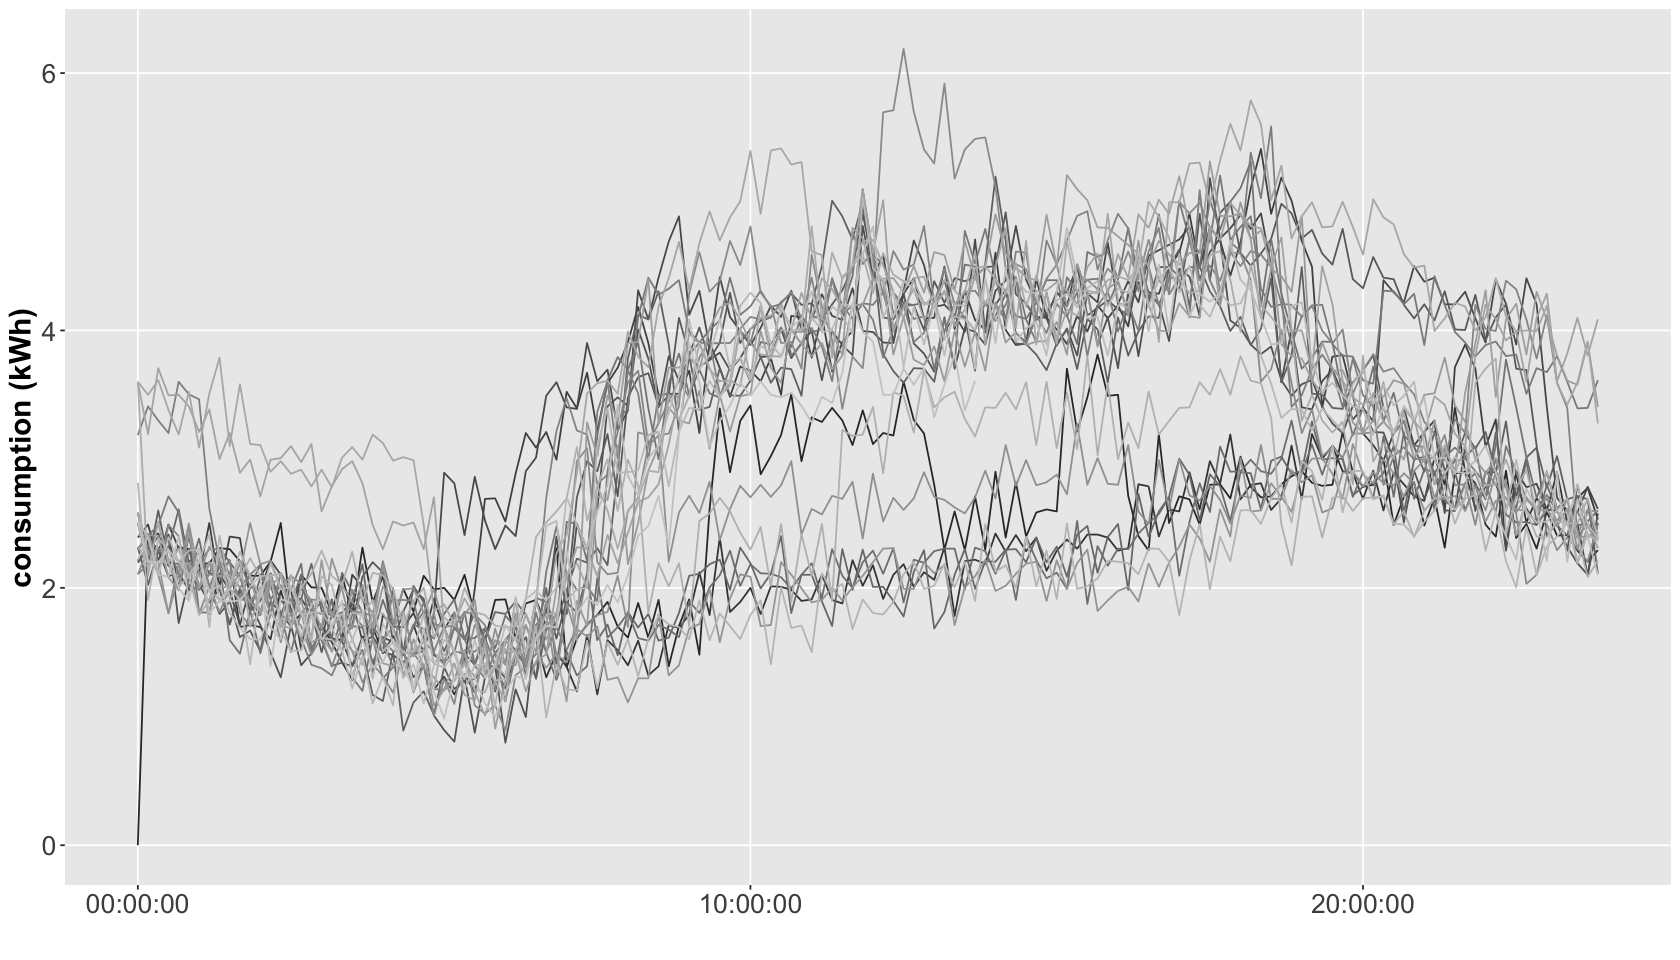

In [9]:
# Plot setting
options(repr.plot.width=14, repr.plot.height=8)
font_theme <- theme(panel.grid.minor = element_blank(), axis.text=element_text(size=16),
                    axis.title=element_text(size=18), title=element_text(size=18,face="bold"))


ggplot(df$bowland_main, aes(x = hour, y = rate)) + 
      geom_line(aes(color = as.factor(day))) + labs(x="time", y="consumption (kWh)") +
      theme(legend.position = "none") + scale_color_grey() +
      labs(x="") + font_theme

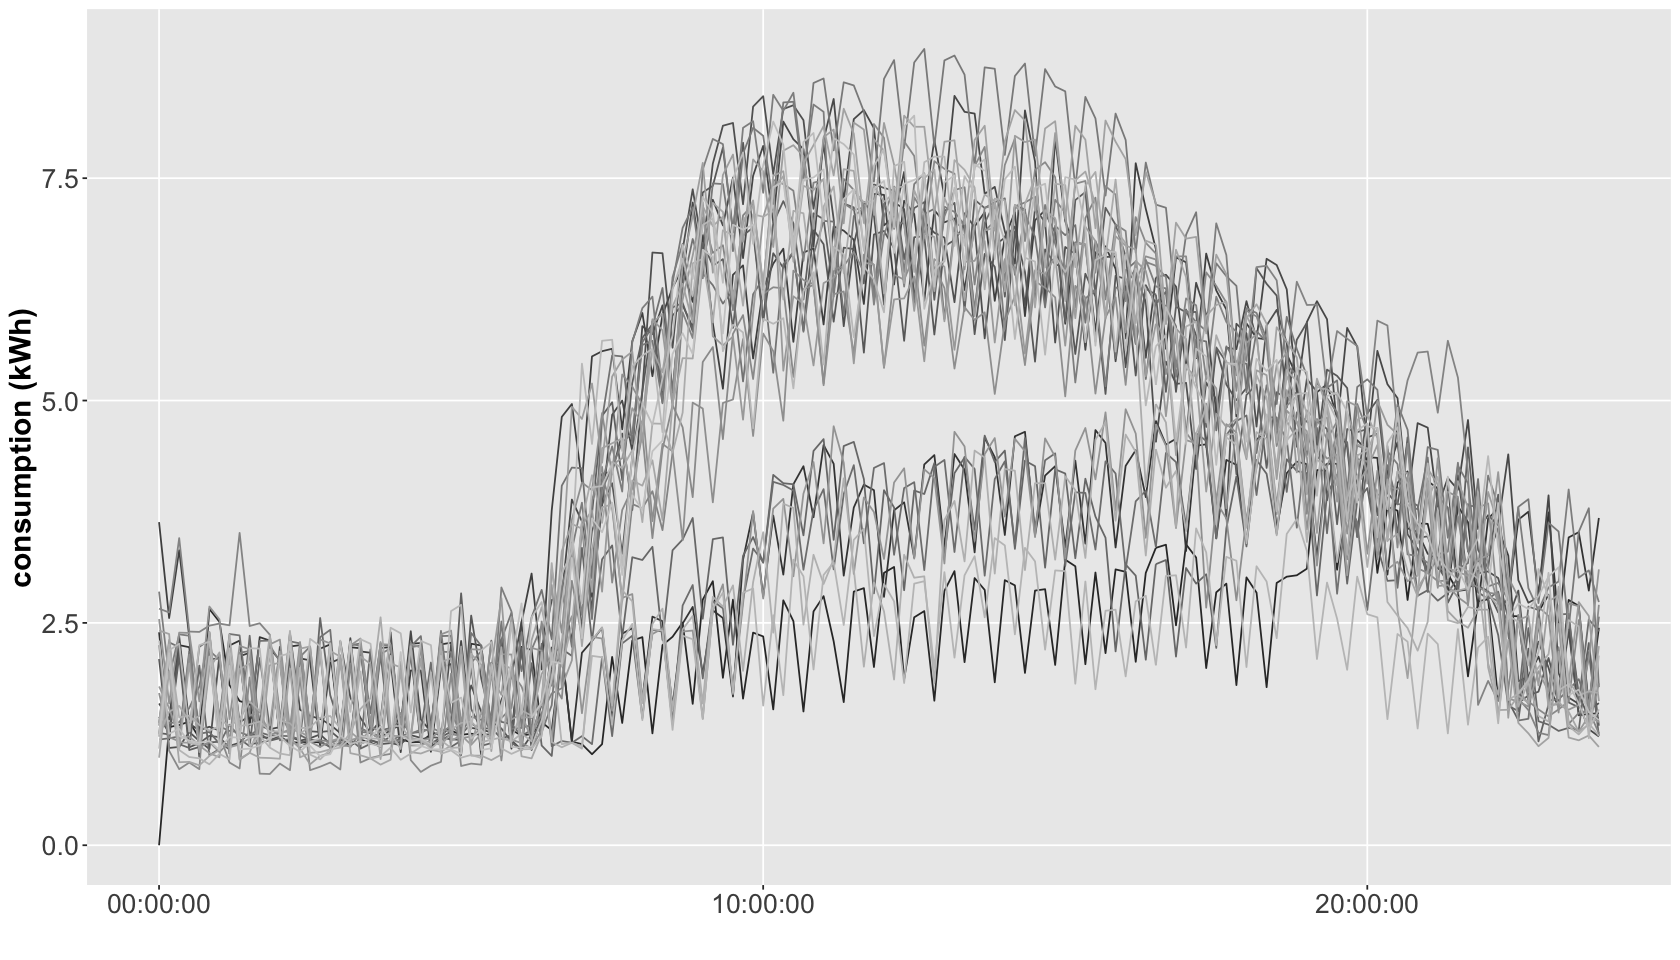

In [10]:
options(repr.plot.width=14, repr.plot.height=8)

ggplot(df$county_south, aes(x = hour, y = rate)) + 
      geom_line(aes(color = as.factor(day))) + labs(x="time", y="consumption (kWh)") +
      theme(legend.position = "none") + scale_color_grey() +
      labs(x="") + font_theme

In [11]:
p <- list()
for(i in names(df)){
  p[[i]] <- ggplot(df[[i]], aes(x = hour, y = rate)) + 
              geom_line(aes(color = as.factor(day))) + labs(x="time", y="consumption") +
              theme(legend.position = "none") + scale_color_grey() +
              labs(x="", title = i) + font_theme
}

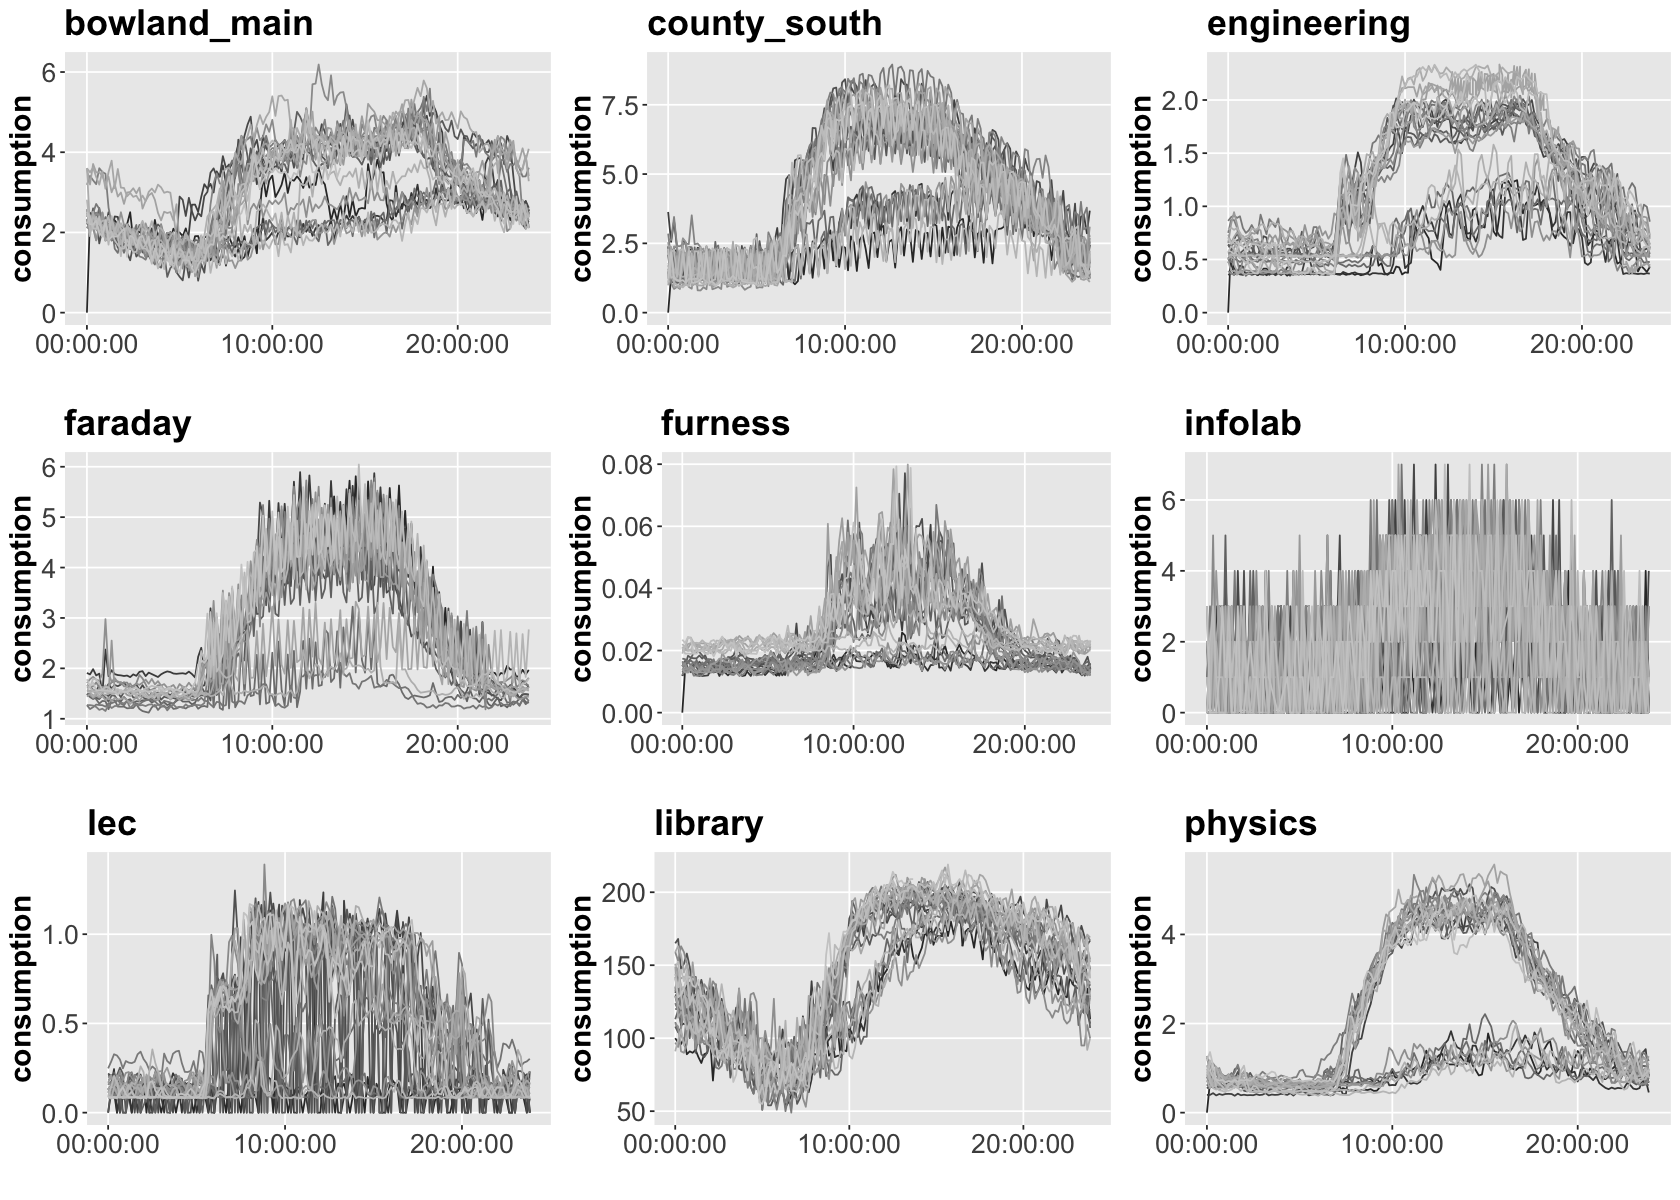

In [13]:
options(repr.plot.width=14, repr.plot.height=10)

grid.arrange(p[[1]], p[[2]], p[[3]],
             p[[4]], p[[5]], p[[6]],
             p[[7]], p[[8]], p[[9]], nrow=3)

In [14]:
p2 <- list()
for(i in names(df)){
  p2[[i]] <- ggplot(df[[i]], aes(x = hour, y = occupancy)) + 
              geom_line(aes(color = as.factor(day))) + labs(x="time", y="occupancy") +
              theme(legend.position = "none") + scale_color_grey() +
              labs(x="", title = i) + font_theme
}

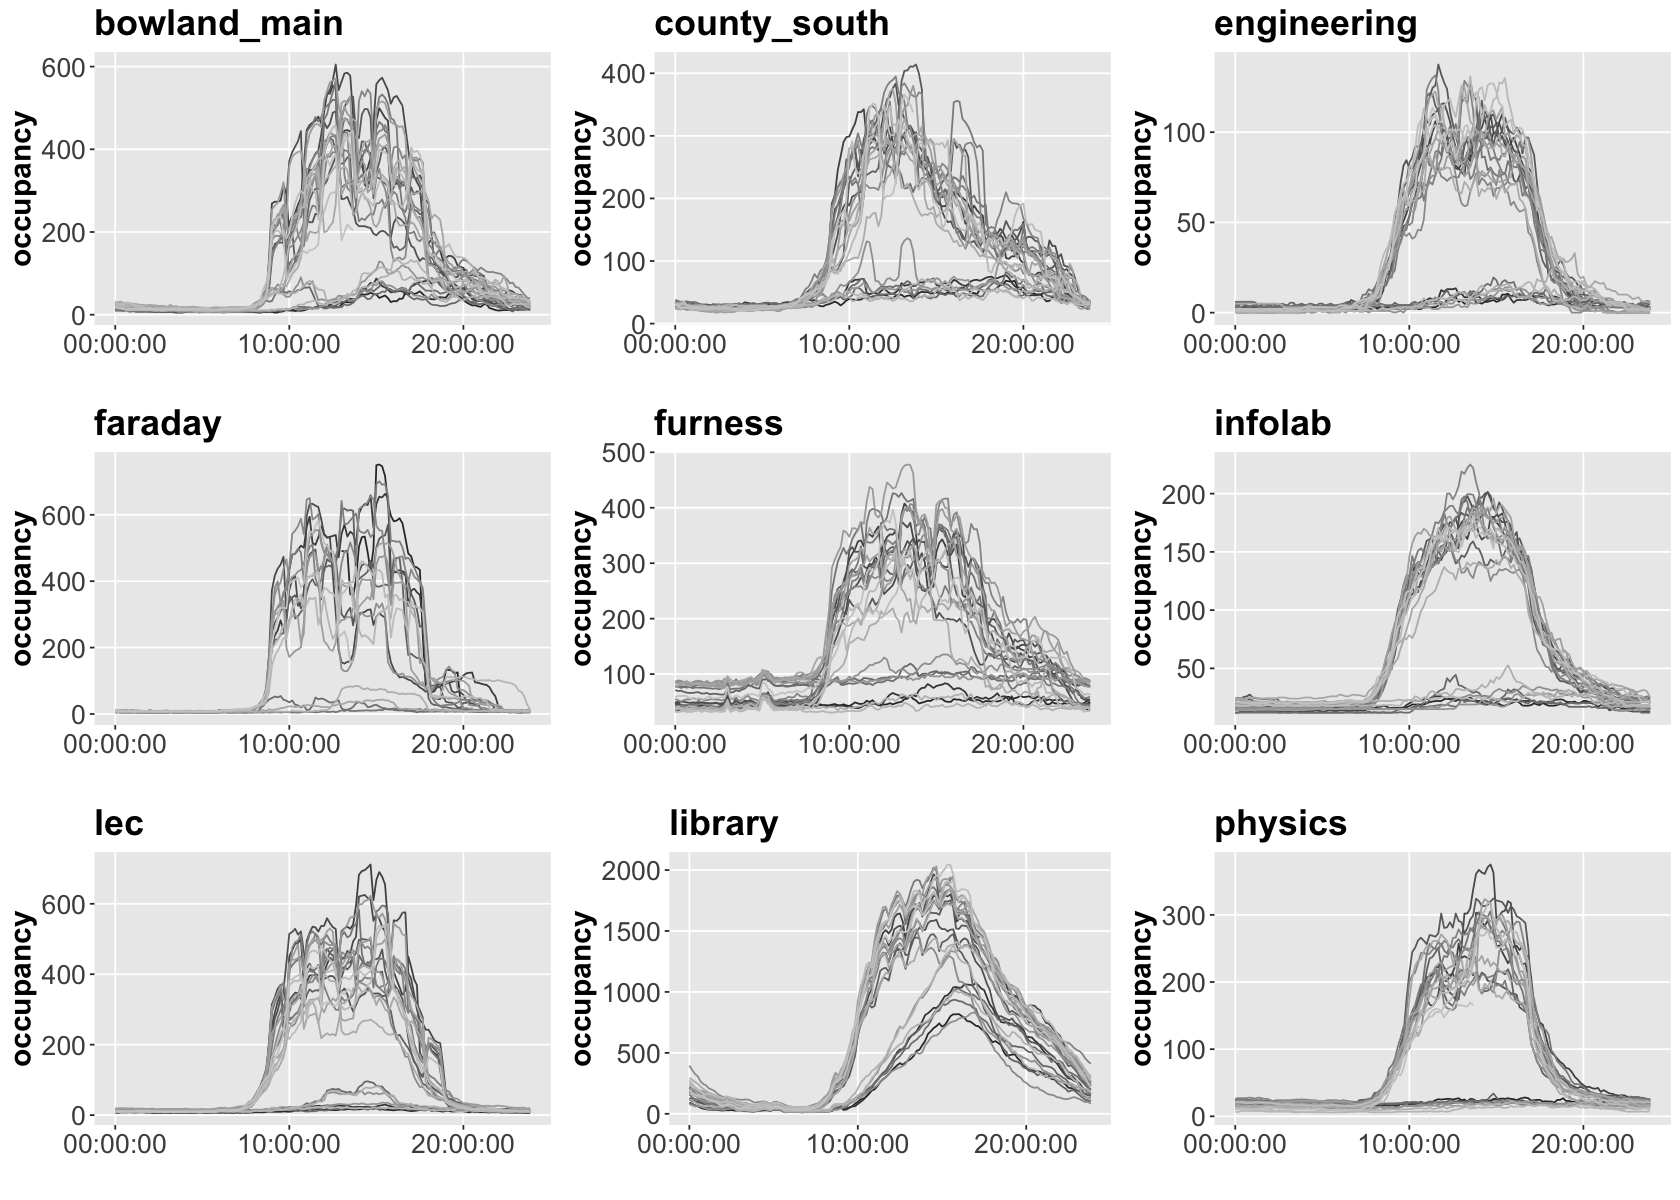

In [15]:
options(repr.plot.width=14, repr.plot.height=10)

grid.arrange(p2[[1]], p2[[2]], p2[[3]],
             p2[[4]], p2[[5]], p2[[6]],
             p2[[7]], p2[[8]], p2[[9]], nrow=3)

## Time-varying coefficient regression

In [27]:
# Fit model to bowland_main dataset

tvLM1 <- tvLM(formula = rate~occupancy*is_weekend, z = df$bowland_main$t, data = df$bowland_main, 
              tkernel  = "Gaussian", est = "lc", bw = 6)
summary(tvLM1)


Call: 
tvLM(formula = rate ~ occupancy * is_weekend, z = df$bowland_main$t, 
    data = df$bowland_main, bw = 6, est = "lc", tkernel = "Gaussian")

Class:  tvlm 

Summary of time-varying estimated coefficients: 
        (Intercept) occupancy is_weekend occupancy:is_weekend
Min.          1.173 0.0001006   -1.74112            -0.017168
1st Qu.       1.912 0.0008070   -1.42042            -0.008119
Median        2.997 0.0065719   -0.60621            -0.005217
Mean          2.921 0.0114440   -0.72477            -0.001756
3rd Qu.       3.974 0.0148793   -0.06729             0.004225
Max.          4.392 0.0480070    0.31961             0.021682

Bandwidth:  6
Pseudo R-squared:  0.8343 



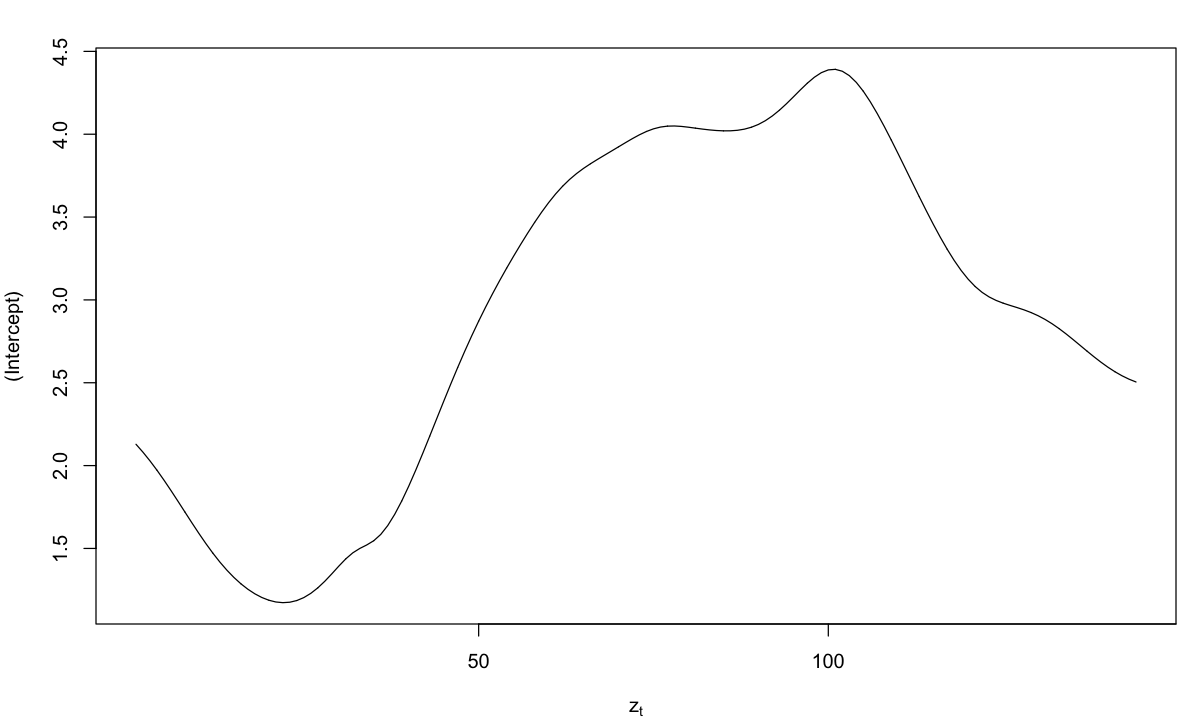

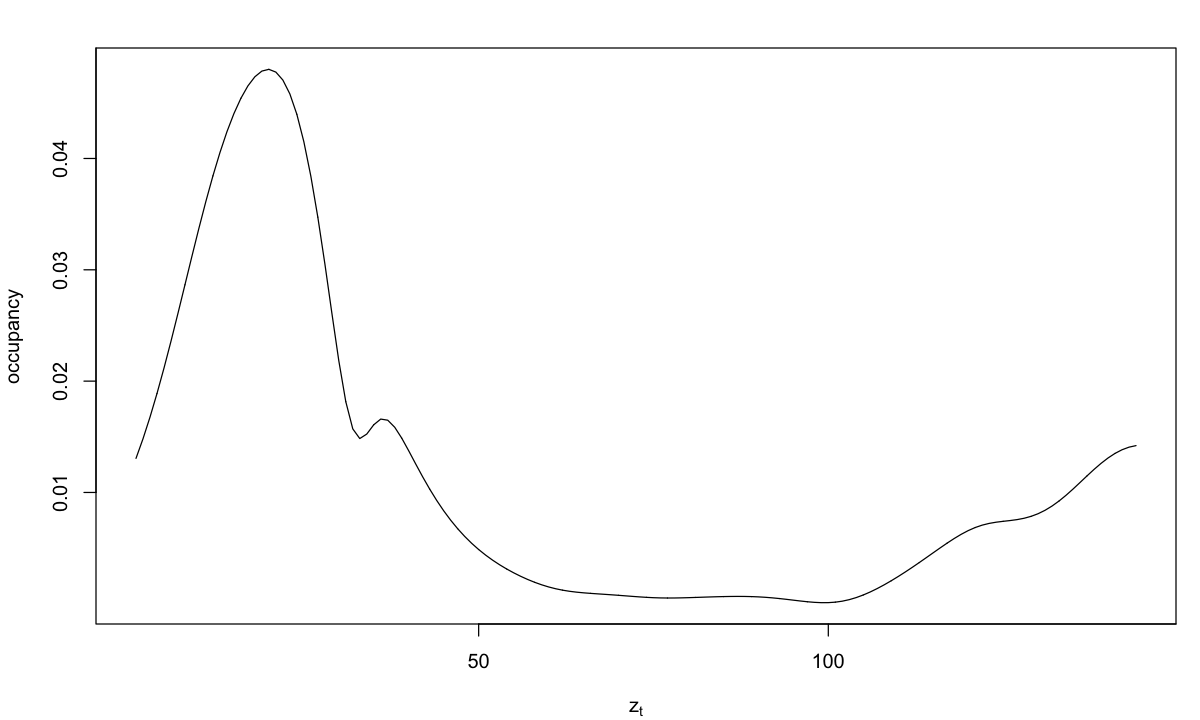

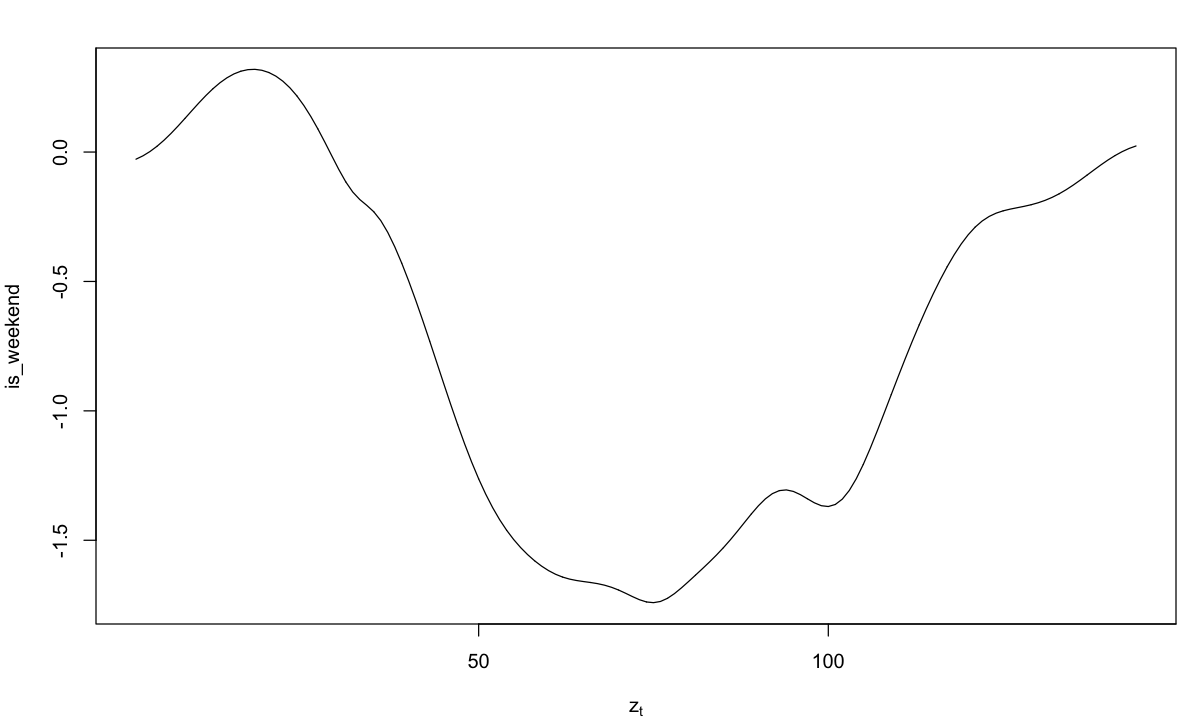

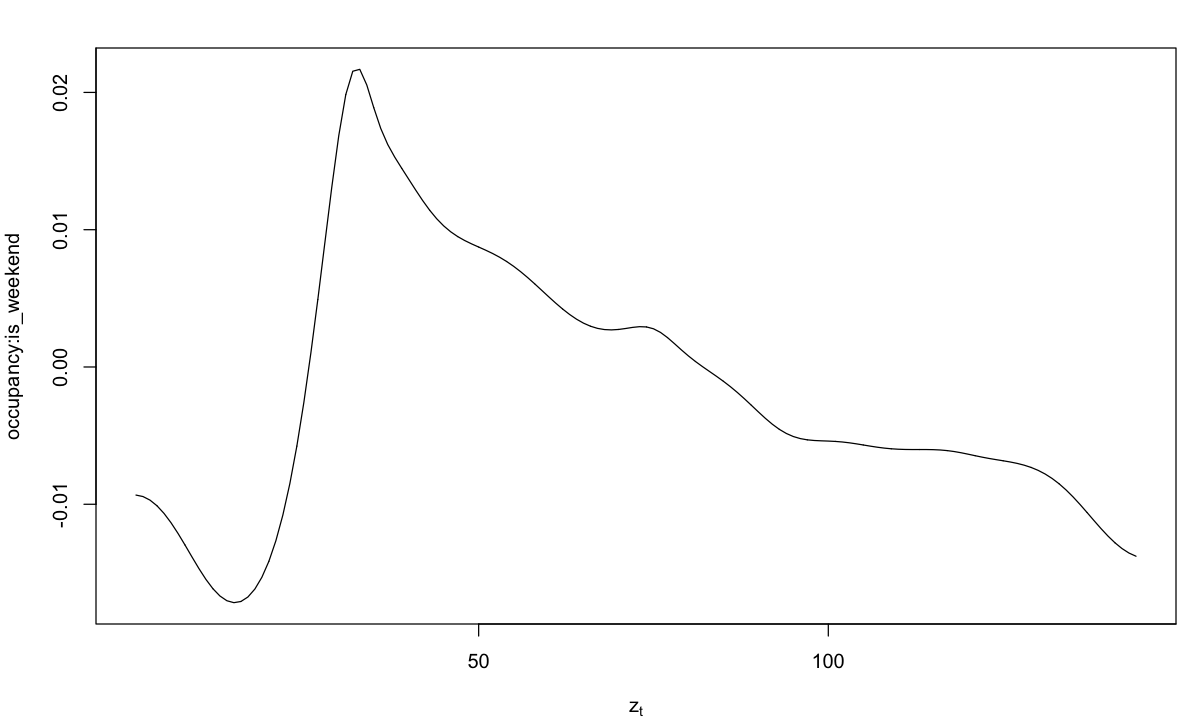

In [25]:
options(repr.plot.width=10, repr.plot.height=6)
plot(tvLM1)

### Run all models

In [30]:
names(df)

[1] "bowland_main" "county_south" "engineering"  "faraday"      "furness"     
[6] "infolab"      "lec"          "library"      "physics"

In [31]:
coef <- list()
for (k in names(df)){
    coef[[k]] <- tvLM(formula = rate~occupancy*is_weekend, z = df[[k]]$t, data = df[[k]], 
                      tkernel  = "Gaussian", est = "lc", bw = 6)$coefficients
}

In [52]:
Nbuilding <- length(coef)

# b0.weekday
b0.weekday <- tibble(t=1:144)
for (i in 1:Nbuilding){
    b0.weekday <- cbind(b0.weekday, coef[[i]][1:144,1])
}
colnames(b0.weekday) <- c("t", names(coef))
# b0.weekday.gather <- b0.weekday %>% 
#                         gather(key="building", value="coefficient", -t)

# b0.weekend
b0.weekend <- tibble(t=1:144)
for (i in 1:Nbuilding){
    b0.weekend <- cbind(b0.weekend, coef[[i]][1:144,1]+coef[[i]][1:144,3])
}
colnames(b0.weekend) <- c("t", names(coef))

# b1.weekday
b1.weekday <- tibble(t=1:144)
for (i in 1:Nbuilding){
    b1.weekday <- cbind(b1.weekday, coef[[i]][1:144,2])
}
colnames(b1.weekday) <- c("t", names(coef))

# b1.weekend
b1.weekend <- tibble(t=1:144)
for (i in 1:Nbuilding){
    b1.weekend <- cbind(b1.weekend, coef[[i]][1:144,2]+coef[[i]][1:144,4])
}
colnames(b1.weekend) <- c("t", names(coef))

In [54]:
head(b0.weekday)
head(b0.weekend)
head(b1.weekday)
head(b1.weekend)

t bowland_main county_south engineering faraday  furness    infolab 
1 1 2.128731     0.4438070    0.5361680   4.128462 0.01575050 1.322832
2 2 2.080720     0.4608275    0.5335655   4.132223 0.01576984 1.307926
3 3 2.028405     0.4819532    0.5308772   4.130402 0.01578870 1.292015
4 4 1.972082     0.5070886    0.5281356   4.124517 0.01580699 1.275387
5 5 1.912246     0.5360148    0.5253777   4.115998 0.01582463 1.258426
6 6 1.849589     0.5683893    0.5226422   4.106103 0.01584156 1.241615
  lec       library  physics  
1 0.1283591 94.10943 0.7449296
2 0.1304048 93.78868 0.7373607
3 0.1323906 93.39139 0.7297573
4 0.1342437 92.91594 0.7221838
5 0.1358831 92.36275 0.7147027
6 0.1372247 91.73443 0.7073726

t bowland_main county_south engineering faraday  furness    infolab  
1 1 2.101174     1.956766     0.5995302   2.069588 0.01932380 0.9624718
2 2 2.066167     1.901012     0.5994685   2.086504 0.01938030 0.9366500
3 3 2.030473     1.843342     0.5995106   2.100147 0.01942910 0.9130575
4 4 1.994282     1.783120     0.5996796   2.110593 0.01946899 0.8919471
5 5 1.957822     1.719735     0.5999953   2.117827 0.01949871 0.8735927
6 6 1.921347     1.652679     0.6004712   2.121744 0.01951711 0.8582958
  lec          library  physics  
1 -0.001879979 95.97363 0.8336607
2  0.001366027 95.77082 0.8093229
3  0.005068086 95.46949 0.7857383
4  0.009168679 95.06529 0.7630203
5  0.013567979 94.55584 0.7412667
6  0.018126143 93.94128 0.7205572

t bowland_main county_south engineering faraday      furness     
1 1 0.01306234   0.04306236   0.01571262  0.0007940182 2.273913e-05
2 2 0.01481959   0.04237378   0.01589176  0.0007991859 2.256648e-05
3 3 0.01676317   0.04154214   0.01606806  0.0008176609 2.243351e-05
4 4 0.01888394   0.04056819   0.01623223  0.0008455611 2.235267e-05
5 5 0.02116430   0.03945646   0.01637377  0.0008790099 2.233716e-05
6 6 0.02357755   0.03821540   0.01648161  0.0009144705 2.239985e-05
  infolab      lec           library   physics      
1 -0.011255034  7.520624e-04 0.2005116 -5.101305e-04
2 -0.010534103  5.353411e-04 0.2023401 -3.957566e-04
3 -0.009781365  3.232974e-04 0.2045730 -2.807257e-04
4 -0.009014186  1.225220e-04 0.2072322 -1.671509e-04
5 -0.008253848 -5.981921e-05 0.2103310 -5.729961e-05
6 -0.007525212 -2.164007e-04 0.2138726  4.641621e-05

t bowland_main county_south engineering faraday     furness      
1 1 0.003731745  -0.013595855 -0.03570367 0.002108112 -5.782015e-05
2 2 0.005381758  -0.011669595 -0.03579326 0.001875825 -5.829925e-05
3 3 0.007065094  -0.009659606 -0.03593179 0.001721799 -5.863340e-05
4 4 0.008774748  -0.007542125 -0.03611923 0.001635858 -5.879989e-05
5 5 0.010502150  -0.005294116 -0.03635286 0.001610665 -5.877642e-05
6 6 0.012237488  -0.002896201 -0.03662679 0.001641386 -5.854290e-05
  infolab       lec         library   physics     
1 -0.0003037044 0.011112706 0.1634476 -0.008749642
2  0.0017254430 0.010844034 0.1678072 -0.007392713
3  0.0036142522 0.010542491 0.1734184 -0.006103720
4  0.0053411546 0.010214135 0.1803846 -0.004890310
5  0.0068821035 0.009868338 0.1887960 -0.003758660
6  0.0082101850 0.009517344 0.1987217 -0.002713189

In [64]:
plot_coef <- function(data, coef_name){
    b0.weekday %>% 
    gather(key="building", value="coefficient", -t) %>%
    ggplot(aes(x=t,y=coefficient)) +
        geom_line() + labs(x="", title=coef_name) +
        facet_wrap(~building, scales = "free") + 
        font_theme + theme(strip.text = element_text(size=15))
}

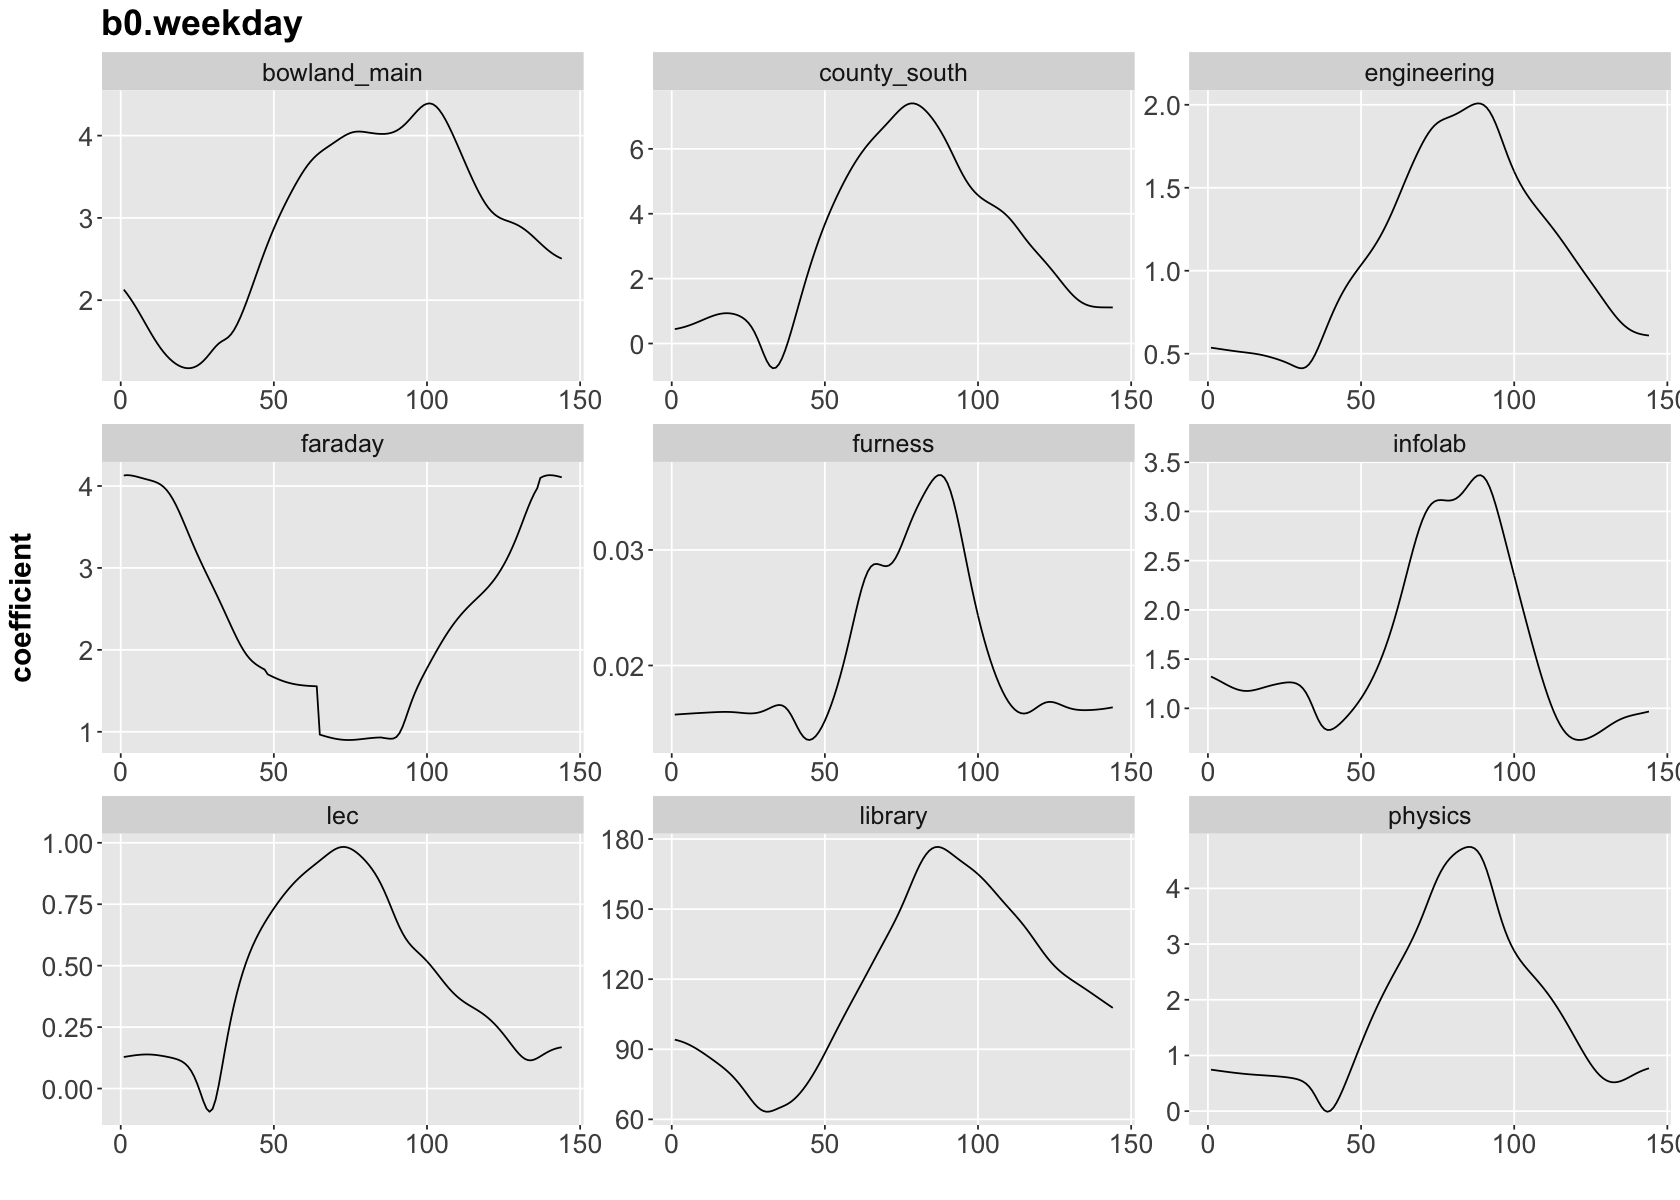

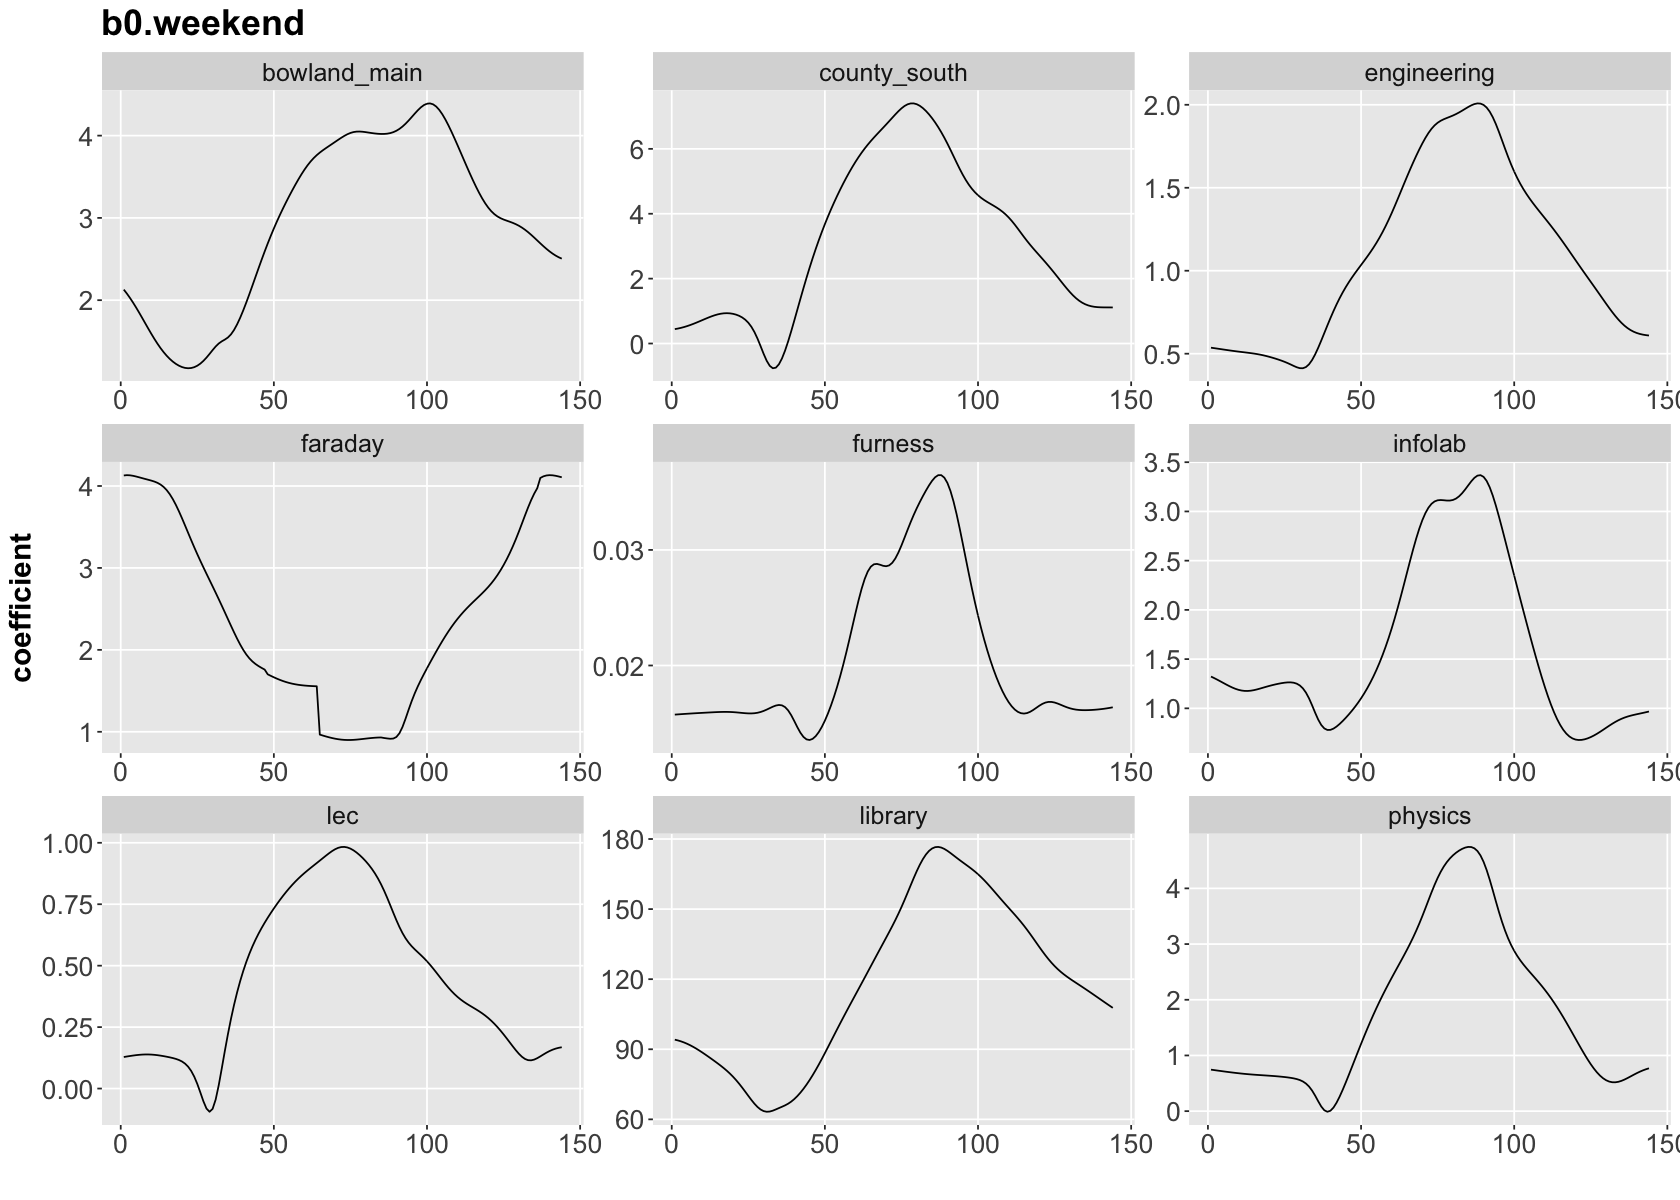

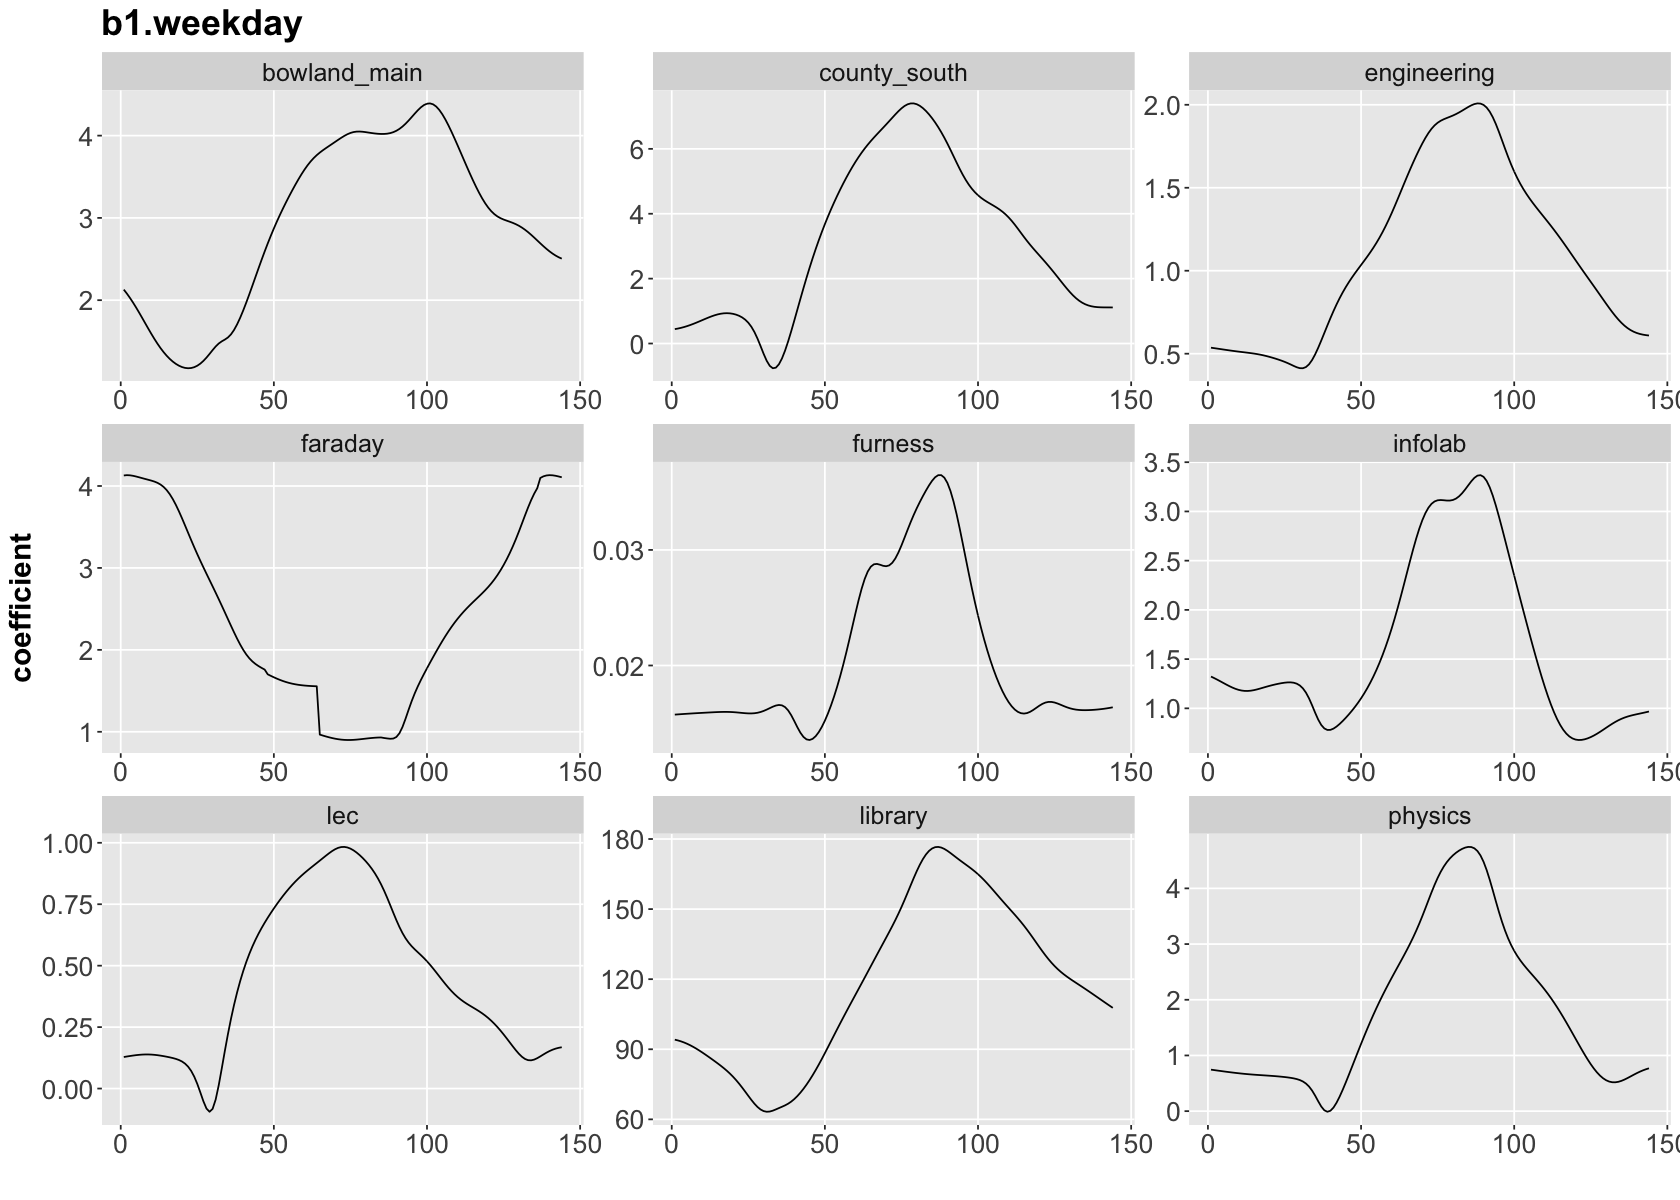

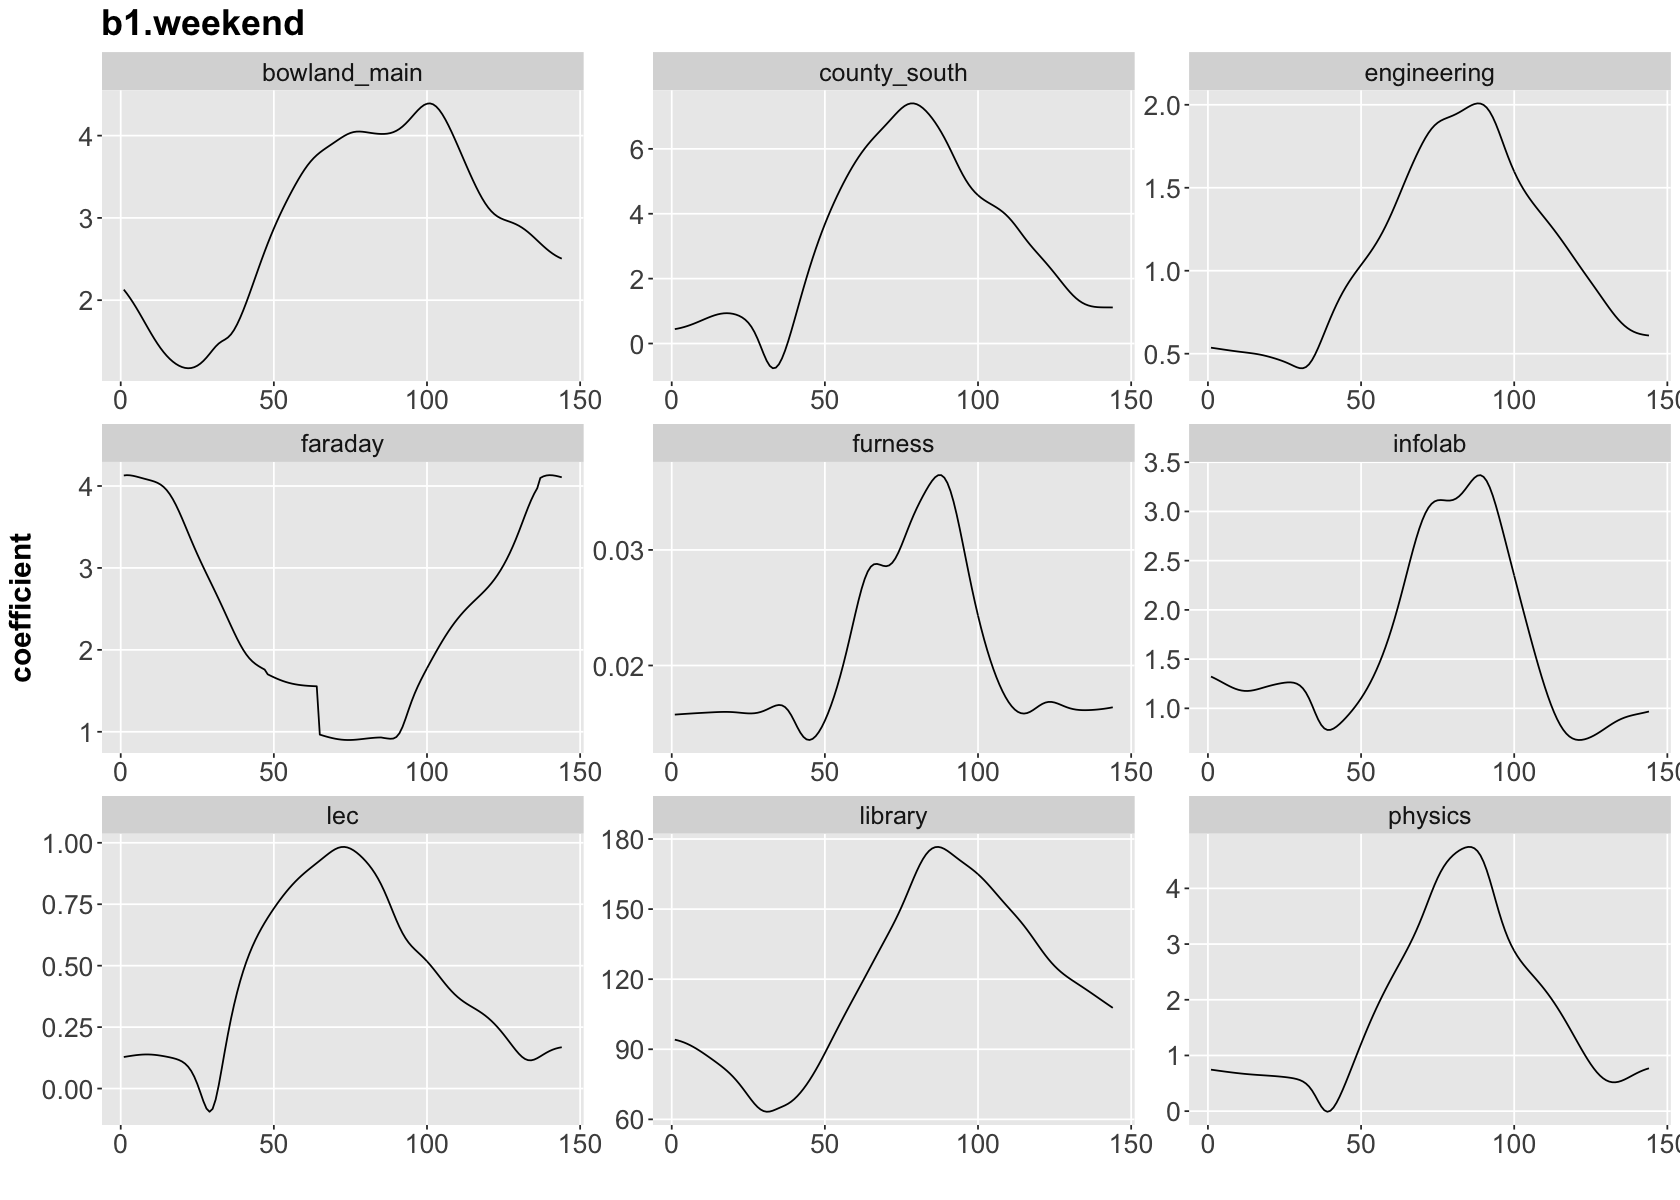

In [66]:
options(repr.plot.width=14, repr.plot.height=10)

plot_coef(b0.weekday, "b0.weekday")
plot_coef(b0.weekend, "b0.weekend")
plot_coef(b1.weekday, "b1.weekday")
plot_coef(b1.weekend, "b1.weekend")

## Time Series Clustering for Coefficients

In [67]:
# cluster analysis
ts_cluster <- function(data){
    d <- data %>% select(-t)
    dist_ts <- TSclust::diss(SERIES = t(d), METHOD = "DTWARP")
    hc <- stats::hclust(dist_ts, method="complete")
    hclus <- stats::cutree(hc, k = 2) %>%
             as.data.frame(.) %>%
             dplyr::rename(.,cluster_group = .) %>%
             tibble::rownames_to_column("type_col")
    hcdata <- ggdendro::dendro_data(hc)
    names_order <- hcdata$labels$label

    p1 <- hcdata %>%
      ggdendro::ggdendrogram(., rotate=TRUE, leaf_labels=FALSE)

    p2 <- d %>%
      dplyr::mutate(index = 1:144) %>%
      tidyr::gather(key = type_col,value = value, -index) %>%
      dplyr::full_join(., hclus, by = "type_col") %>% 
      mutate(type_col = factor(type_col, levels = rev(as.character(names_order)))) %>% 
      ggplot(aes(x = index, y = value, colour = cluster_group)) +
      geom_line() +
      facet_wrap(~type_col, ncol = 1, strip.position="left", scales = "free") + 
      guides(color=FALSE) +
      theme_bw() + 
      theme(strip.background = element_blank(), strip.text = element_blank())

    gp1<-ggplotGrob(p1)
    gp2<-ggplotGrob(p2) 

    options(repr.plot.width=12, repr.plot.height=12)
    grid.arrange(gp2, gp1, ncol=2, widths=c(2,4))
}

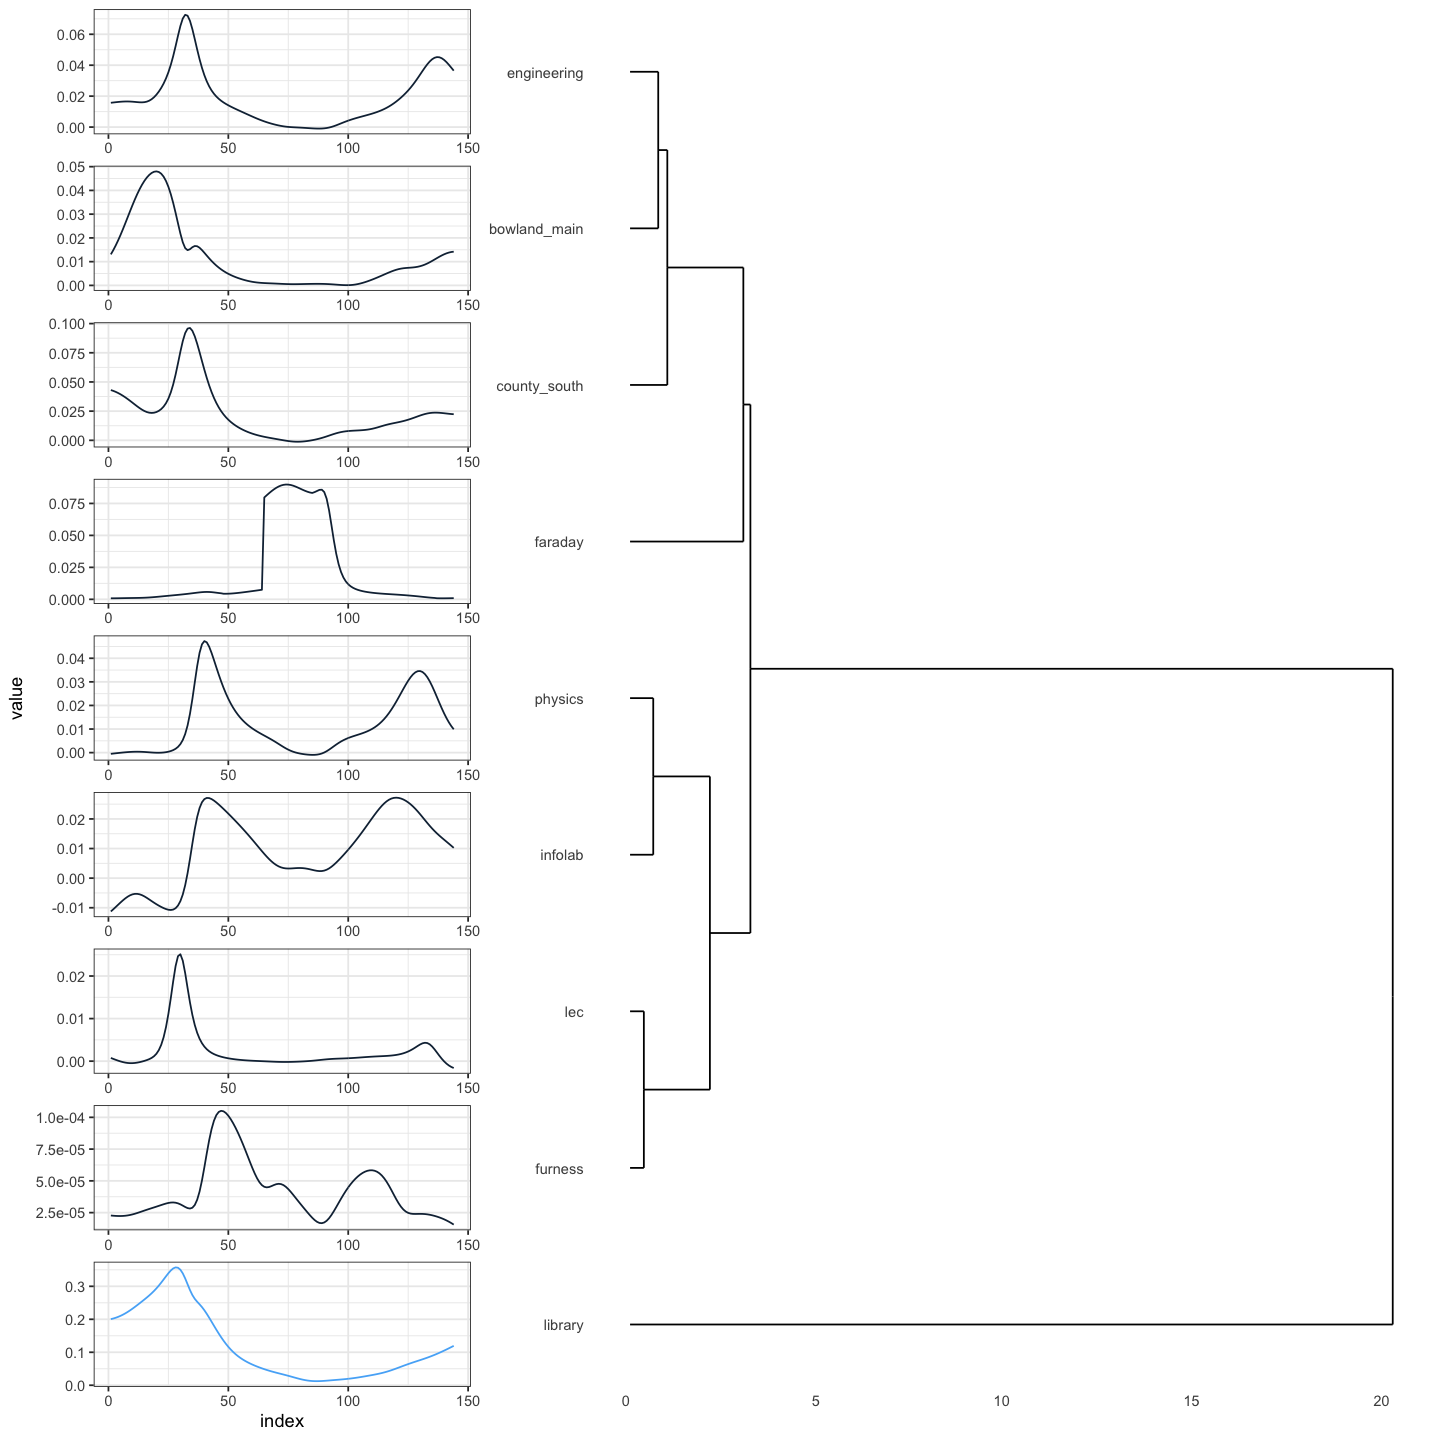

In [70]:
ts_cluster(b1.weekday)

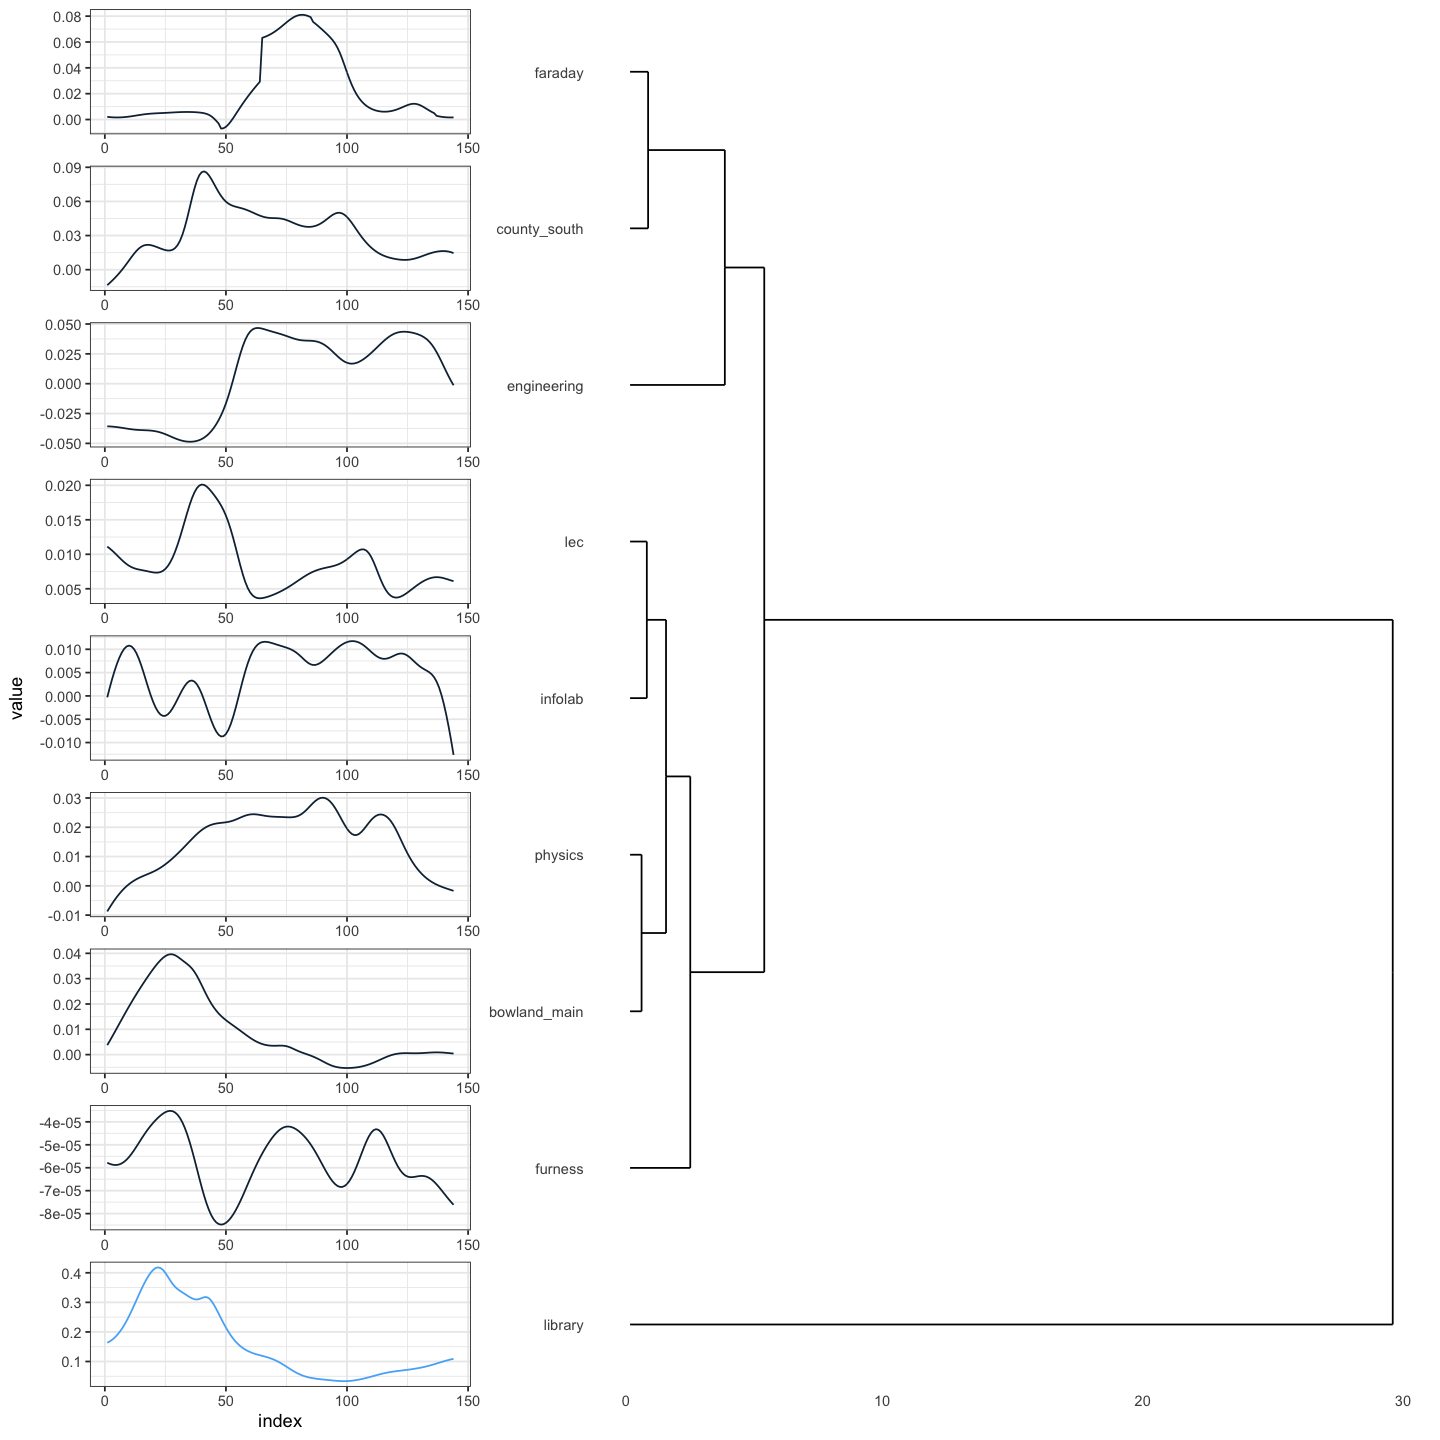

In [69]:
ts_cluster(b1.weekend)

## Forecast energy consumption

In [73]:
unique(df[[1]]$day)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26

In [107]:
df.lib <- df[["library"]] %>% 
            filter(day<26) %>%
            mutate(is_weekeend_occupancy = is_weekend * occupancy)

In [108]:
train <- df.lib %>% filter(day<25)
test  <- df.lib %>% filter(day==25)
train.df <- train %>% select(ts, rate) %>% rename(ds=ts, y=rate)

### Prophet Forecast

In [89]:
m1 <- prophet(train.df)

Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.



In [90]:
future       <- df.lib %>% select(ts) %>% rename(ds = ts)
m1.forecast  <- predict(m1, future)

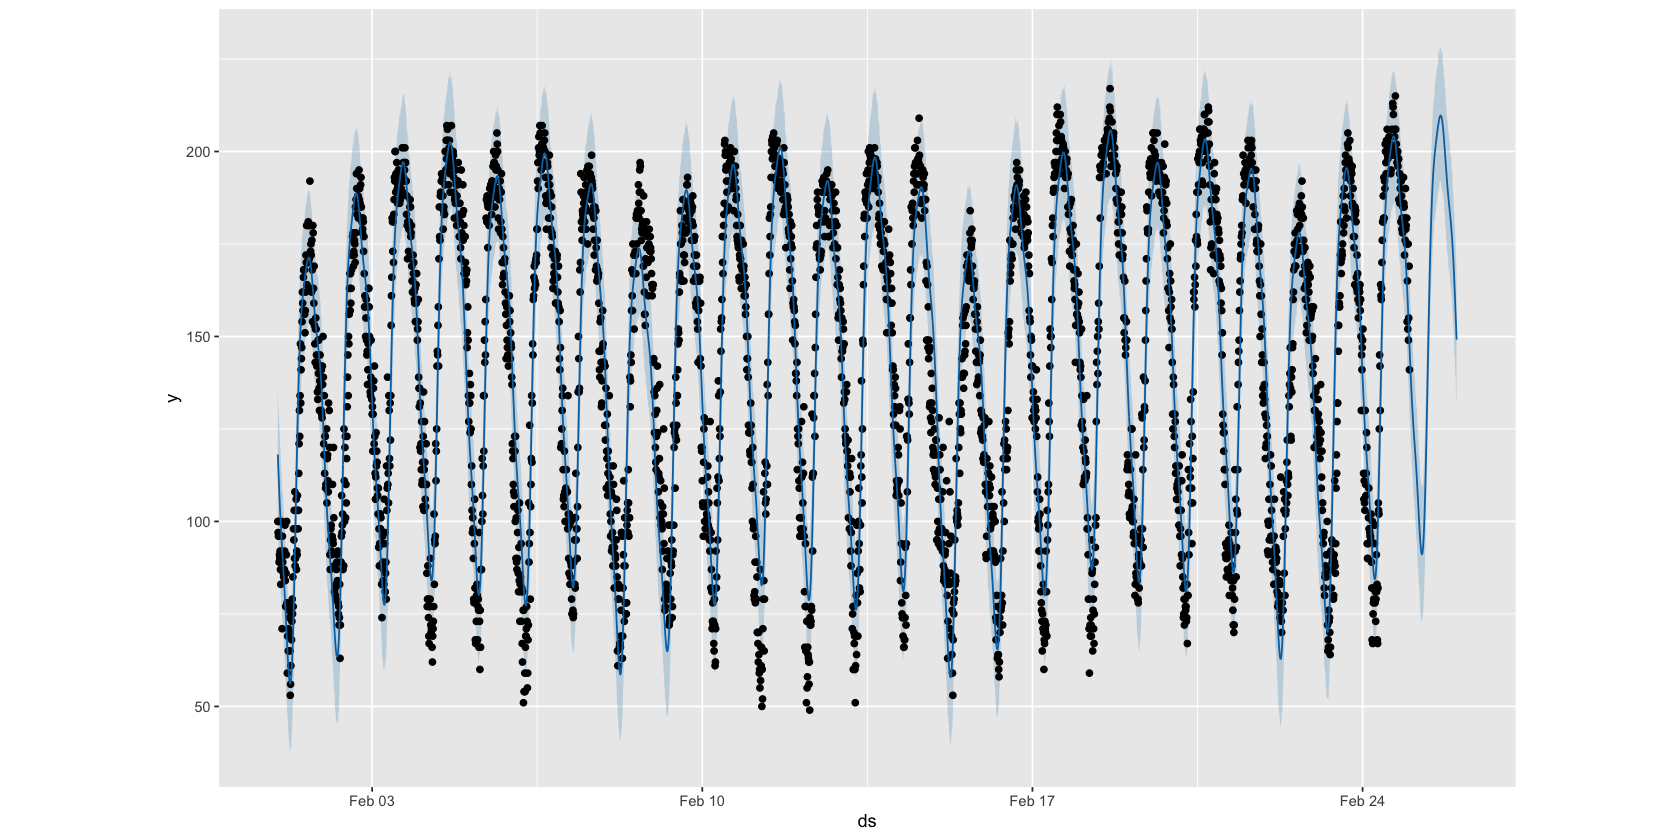

In [91]:
options(repr.plot.width=14, repr.plot.height=7)
plot(m1, m1.forecast)

### TBATS

In [92]:
y <- ts(train.df$y, start = 1, frequency = 144)

In [93]:
m2 <- tbats(y, seasonal.periods = 144)
m2

TBATS(1, {1,2}, -, {<144,6>})

Call: tbats(y = y, seasonal.periods = 144)

Parameters
  Alpha: 0.005480689
  Gamma-1 Values: 1.816781e-05
  Gamma-2 Values: 2.646685e-05
  AR coefficients: 0.962471
  MA coefficients: -0.442948 -0.120965

Seed States:
              [,1]
 [1,] 119.02141415
 [2,] -19.51470257
 [3,]  12.90544571
 [4,]  -3.36580748
 [5,]  -1.29793382
 [6,]  -0.34182419
 [7,]  -0.06701884
 [8,] -50.16107194
 [9,]   2.43369621
[10,]   3.09262551
[11,]  -3.60933180
[12,]  -0.88071428
[13,]  -0.18891199
[14,]   0.00000000
[15,]   0.00000000
[16,]   0.00000000

Sigma: 8.889011
AIC: 43304.48

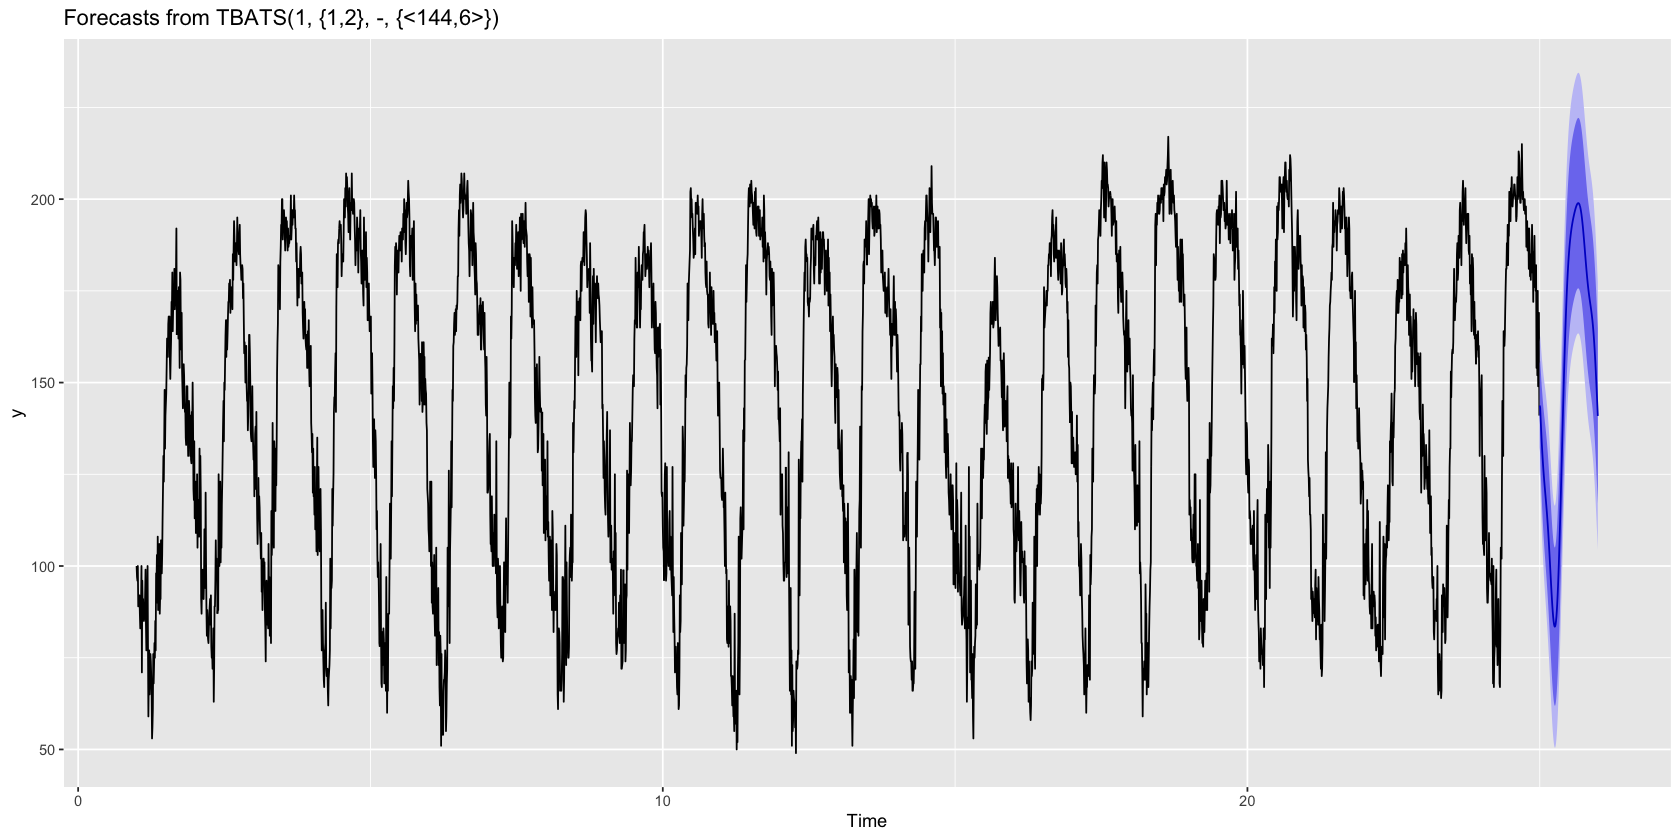

In [94]:
options(repr.plot.width=14, repr.plot.height=7)
forecast::forecast(m2, h = 144) %>% autoplot()

### Auto ARIMA

In [95]:
m3 <- auto.arima(y, max.d = 1, max.D = 1) 
summary(m3)

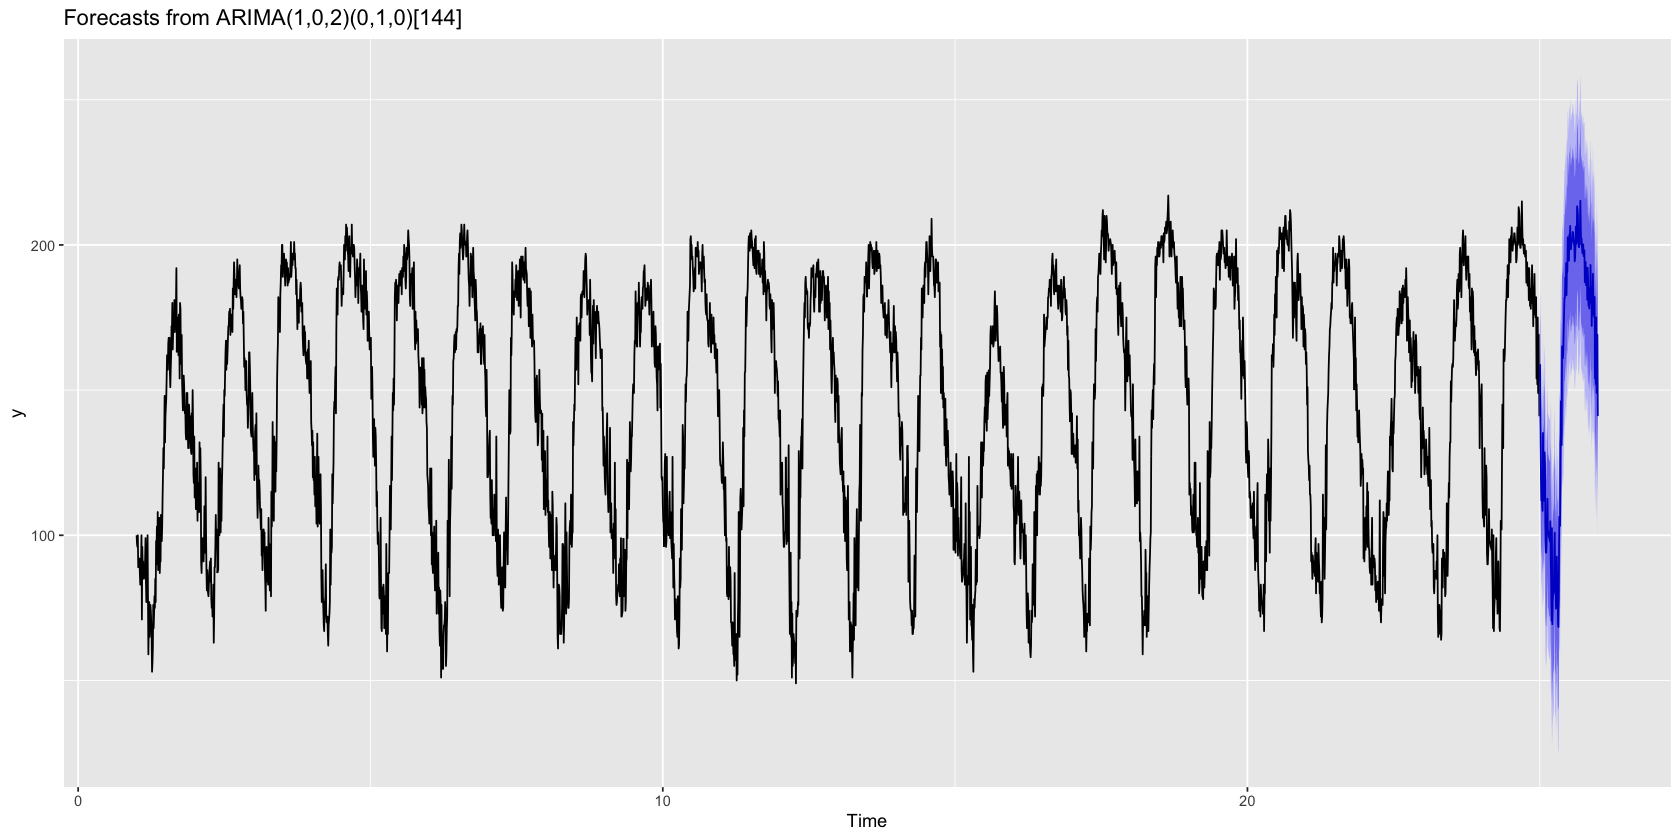

In [96]:
options(repr.plot.width=14, repr.plot.height=7)
forecast::forecast(m3, h = 144) %>% autoplot()

### STL

In [97]:
m4 <- stlm(y)

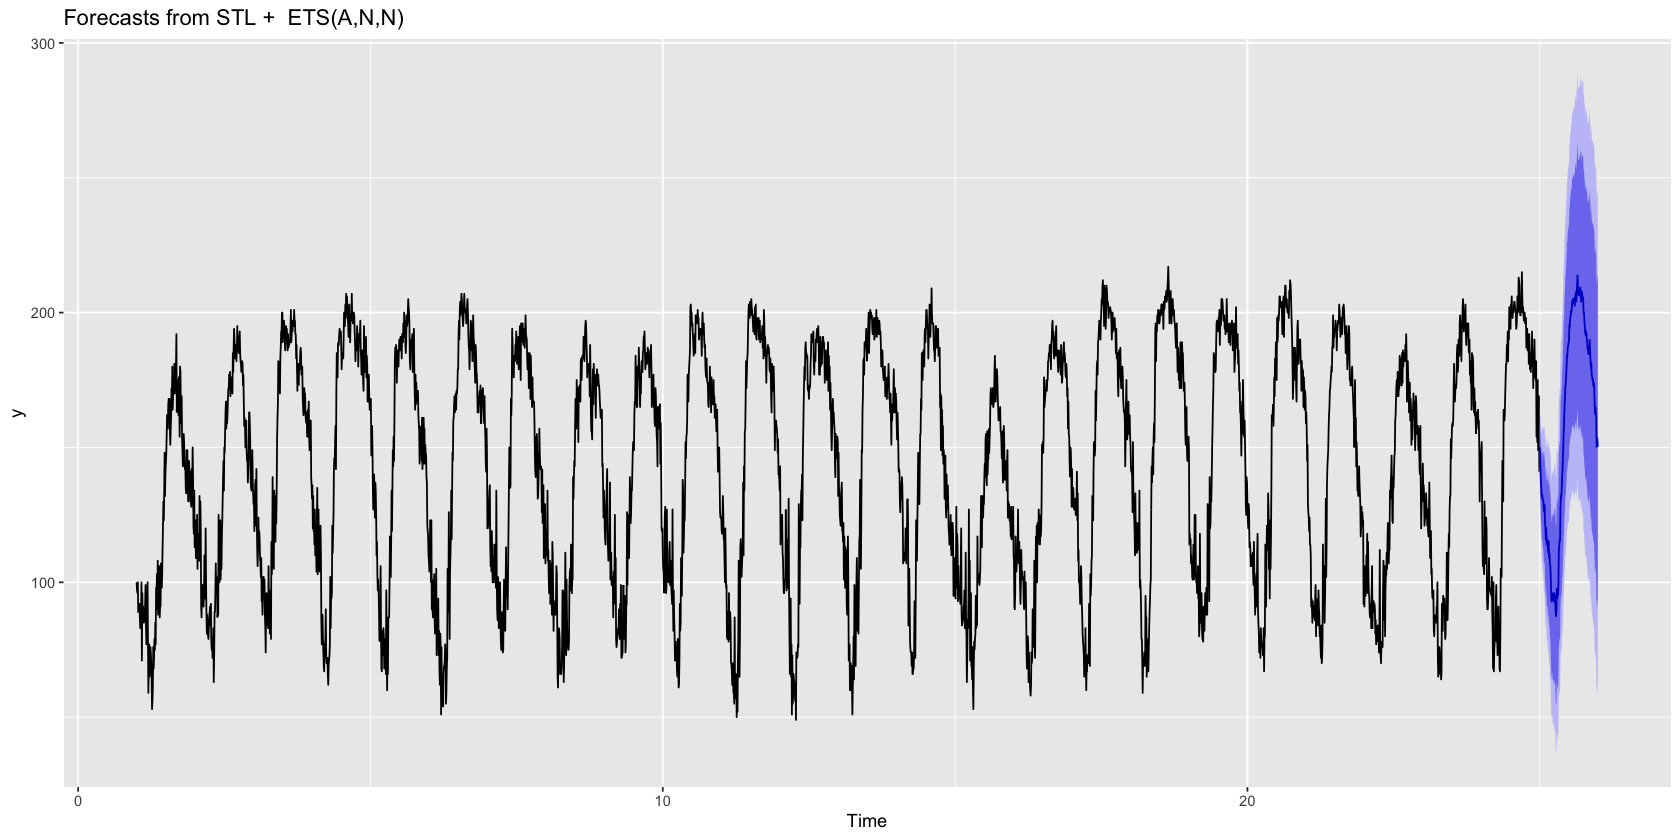

In [98]:
options(repr.plot.width=14, repr.plot.height=7)
forecast::forecast(m4, h = 144) %>% autoplot()

### Time-varying coefficient regression

In [101]:
# Bandwidth = 6 (1 hour)
m5 <- tvLM(formula = rate~occupancy*is_weekend, z = train$t, data = train, 
           tkernel  = "Gaussian", est = "lc", bw = 6)

# Optimal bandwidth
m6 <- tvLM(formula = rate~occupancy*is_weekend, z = train$t, data = train, 
           tkernel  = "Gaussian", est = "lc")

Calculating regression bandwidth... bw =  1.814075 


### Forecast Comparison

In [115]:
prediction <- test %>% select(ts, rate) %>% rename(actual = rate, time = ts)
n_test <- dim(prediction)[1]
prediction['Prophet'] <- m1.forecast %>% select(yhat) %>% slice_tail(n = n_test)
prediction['TBATS'] <- forecast::forecast(m2, h = n_test)$mean
prediction['ARIMA'] <- forecast::forecast(m3, h = n_test)$mean
prediction['STLF'] <- forecast::forecast(m4, h = n_test)$mean
prediction["tvReg"] <- predict(m5, as.matrix(test %>% 
                                             select(occupancy,
                                                    is_weekend, 
                                                    is_weekeend_occupancy)), test$t)
prediction["tvRegOptim"] <- predict(m6, as.matrix(test %>% 
                                                  select(occupancy,
                                                         is_weekend, 
                                                         is_weekeend_occupancy)), test$t)

In [116]:
head(prediction)

time                actual Prophet  TBATS    ARIMA    STLF     tvReg   
1 2020-02-25 00:00:00 141    145.6580 143.7500 152.6893 149.9952 142.9059
2 2020-02-25 00:10:00 135    143.4992 143.1283 158.6607 144.3852 138.1094
3 2020-02-25 00:20:00 147    141.3916 140.5327 136.4357 141.5370 136.9525
4 2020-02-25 00:30:00 139    139.3474 138.0516 119.2184 137.3073 134.0259
5 2020-02-25 00:40:00 146    137.3770 135.7023 112.0084 134.8344 131.8852
6 2020-02-25 00:50:00 123    135.4875 133.4968 116.8055 131.6417 124.5157
  tvRegOptim
1 142.3511  
2 137.6641  
3 136.9256  
4 134.4382  
5 132.6232  
6 126.0178

In [162]:
plotForecast <- function(data){
  p1 <- ggplot(data = data) + 
        geom_line(color = "red", aes(x = time, y = actual), size = 0.2) +
        geom_line(color = "black", aes(x = time, y = Prophet)) + 
        xlab("") + ylab("") + ggtitle("Prophet") + scale_x_datetime(date_labels = "%H:%M") +
        font_theme

  p2 <- ggplot(data = data) + 
        geom_line(color = "red", aes(x = time, y = actual), size = 0.2) +
        geom_line(color = "black", aes(x = time, y = ARIMA)) +
        xlab("") + ylab("") + ggtitle("ARIMA") + scale_x_datetime(date_labels = "%H:%M") +
        font_theme
  
  p3 <- ggplot(data = data) + 
        geom_line(color = "red", aes(x = time, y = actual), size = 0.2) +
        geom_line(color = "black", aes(x = time, y = TBATS)) + 
        xlab("") + ylab("") + ggtitle("TBATS") + scale_x_datetime(date_labels = "%H:%M") +
        font_theme
  
  p4 <- ggplot(data = data) + 
        geom_line(color = "red", aes(x = time, y = actual), size = 0.2) +
        geom_line(color = "black", aes(x = time, y = STLF)) +
        xlab("") + ylab("") + ggtitle("STLF") + scale_x_datetime(date_labels = "%H:%M") +
        font_theme
   
  p5 <- ggplot(data = data) + 
        geom_line(color = "red", aes(x = time, y = actual), size = 0.2) +
        geom_line(color = "black", aes(x = time, y = tvReg)) +
        xlab("") + ylab("") + ggtitle("tvReg") + scale_x_datetime(date_labels = "%H:%M") +
        font_theme
        
  p6 <- ggplot(data = data) + 
        geom_line(color = "red", aes(x = time, y = actual), size = 0.2) +
        geom_line(color = "black", aes(x = time, y = tvRegOptim)) +
        xlab("") + ylab("") + ggtitle("tvRegOptim") + scale_x_datetime(date_labels = "%H:%M") +
        font_theme
  options(repr.plot.width=14, repr.plot.height=7)     
  grid.arrange(p1,p2,p3,p4,p5,p6,nrow=2)
}

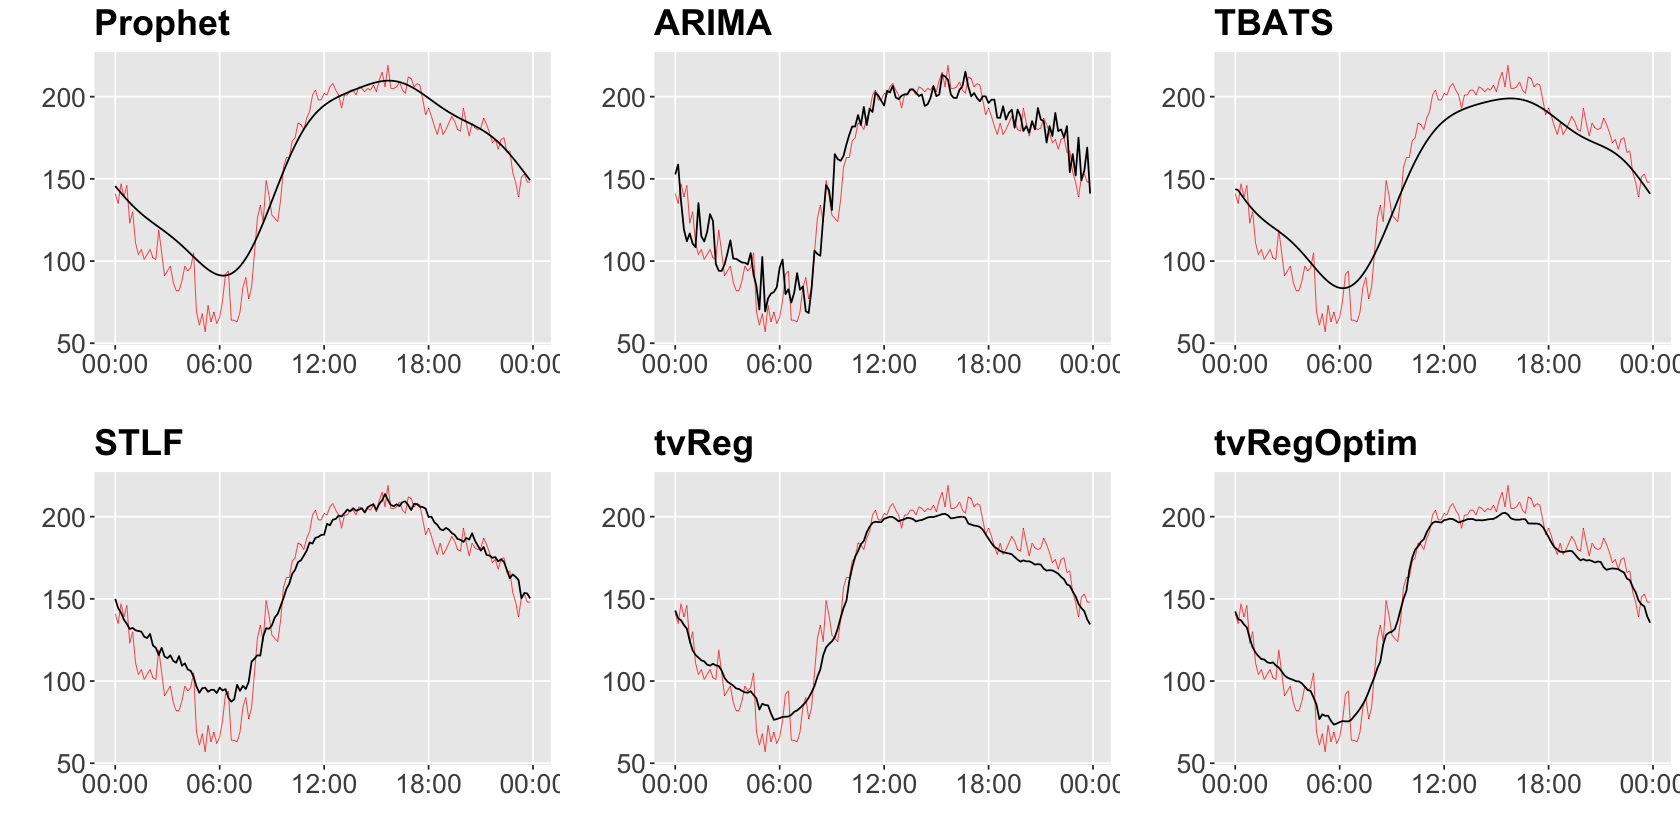

In [163]:
plotForecast(prediction)

In [145]:
rmse.24h  <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = rmse, actual = prediction$actual) 
mape.24h  <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = mape, actual = prediction$actual)
smape.24h <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = smape, actual = prediction$actual)

In [148]:
print(rmse.24h)

   Prophet      TBATS      ARIMA       STLF      tvReg tvRegOptim 
 14.182628  13.960238  13.311924  14.173845  10.277803   9.447327 


In [149]:
print(mape.24h)

   Prophet      TBATS      ARIMA       STLF      tvReg tvRegOptim 
0.10475807 0.10218544 0.08764947 0.10554508 0.07047762 0.06550063 


In [150]:
print(smape.24h)

   Prophet      TBATS      ARIMA       STLF      tvReg tvRegOptim 
0.09238512 0.09575601 0.08267374 0.09384127 0.06837187 0.06376805 


### 7-day ahead forecast

In [159]:
applyForecast <- function(data,h){
  train <- df.lib %>% filter(day<=25-h)
  test  <- df.lib %>% filter(day>25-h)
  train.df <- train %>% select(ts, rate) %>% rename(ds=ts, y=rate)
  prediction <- test %>% select(ts, rate) %>% rename(actual = rate, time = ts)
  n_test <- dim(prediction)[1]
  # Prophet
  m1 <- prophet(train.df)
  future   <- data %>% select(ts) %>% rename(ds = ts)
  m1.forecast <- predict(m1, future)
  # TBATS
  y <- ts(train.df$y, start = 1, frequency = 144)
  m2 <- tbats(y, seasonal.periods = 144)
  # ARIMA
  m3 <- auto.arima(y, max.d = 1, max.D = 1) 
  # STLF
  m4 <- stlf(y, h = n_test)
  # tvReg
  m5 <- tvLM(formula = rate~occupancy*is_weekend, z = train$t, data = train, 
             tkernel  = "Gaussian", est = "lc", bw = 6)
  m6 <- tvLM(formula = rate~occupancy*is_weekend, z = train$t, data = train, 
             tkernel  = "Gaussian", est = "lc")
  # forecast
  prediction['Prophet'] <- m1.forecast %>% select(yhat) %>% slice_tail(n = n_test)
  prediction['TBATS'] <- forecast::forecast(m2, h = n_test)$mean
  prediction['ARIMA'] <- forecast::forecast(m3, h = n_test)$mean
  prediction['STLF'] <- forecast::forecast(m4, h = n_test)$mean
  prediction["tvReg"] <- predict(m5, as.matrix(test %>% 
                                               select(occupancy,
                                                      is_weekend, 
                                                      is_weekeend_occupancy)), test$t)
  prediction["tvRegOptim"] <- predict(m6, as.matrix(test %>% 
                                                    select(occupancy,
                                                           is_weekend, 
                                                           is_weekeend_occupancy)), test$t)
  
  # evaluation
  RMSE  <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = rmse, actual = prediction$actual)
  MAPE  <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = mape, actual = prediction$actual)
  SMAPE <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = smape, actual = prediction$actual)
  
  results <- list(prediction=prediction, 
                  RMSE=RMSE,
                  MAPE=MAPE,
                  SMAPE=SMAPE)
}

In [160]:
forecast7 <- applyForecast(df.lib,7)

Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.



Calculating regression bandwidth... bw =  1.766844 


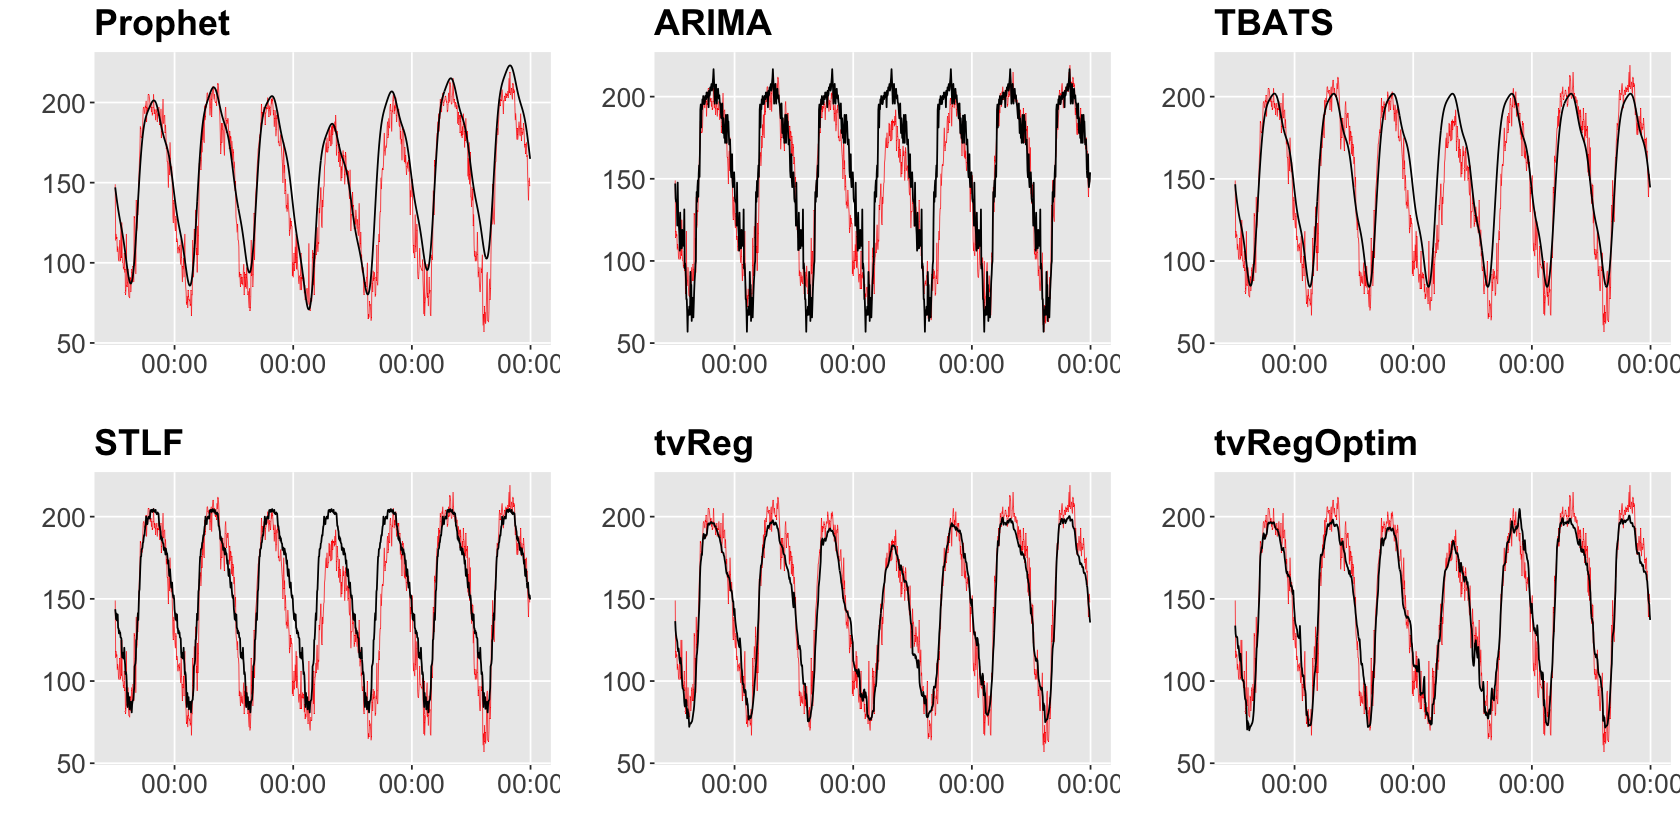

In [164]:
plotForecast(forecast7$prediction)

In [165]:
print(forecast7$RMSE)

   Prophet      TBATS      ARIMA       STLF      tvReg tvRegOptim 
  17.96792   17.72436   20.87374   19.08085   11.44385   11.43434 


In [166]:
print(forecast7$MAPE)

   Prophet      TBATS      ARIMA       STLF      tvReg tvRegOptim 
0.11834041 0.11235251 0.12056315 0.11957601 0.07258142 0.07255143 


In [167]:
print(forecast7$SMAPE)

   Prophet      TBATS      ARIMA       STLF      tvReg tvRegOptim 
0.10601353 0.10257057 0.11202328 0.10771435 0.07182911 0.07134012 


## Forecast Multiple Buildings

In [187]:
tvLMForecast <- function(data,h){
  train <- data %>% filter(day<=25-h)
  test  <- data %>% filter(day>25-h)
  train.df <- train %>% select(ts, rate) %>% rename(ds=ts, y=rate)
  prediction <- test %>% select(ts, rate) %>% rename(actual = rate, time = ts)
  n_test <- dim(prediction)[1]
  
  m <- tvLM(formula = rate~occupancy*is_weekend, z = train$t, data = train, 
            tkernel  = "Gaussian", est = "lc", bw = 6)

  prediction["tvReg"] <- predict(m, as.matrix(test %>% 
                                                    select(occupancy,
                                                           is_weekend, 
                                                           is_weekeend_occupancy)), test$t)
  
  RMSE  <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = rmse, actual = prediction$actual)
  MAPE  <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = mape, actual = prediction$actual)
  SMAPE <- apply(X = prediction[,-c(1,2)], MARGIN = 2, FUN = smape, actual = prediction$actual)
  
  results <- list(prediction=prediction, 
                  RMSE=RMSE,
                  MAPE=MAPE,
                  SMAPE=SMAPE)
}

In [178]:
names(df)

[1] "bowland_main" "county_south" "engineering"  "faraday"      "furness"     
[6] "infolab"      "lec"          "library"      "physics"

In [175]:
removeDay26 <- function(data) {
    data %>%
       filter(day<26) %>%
       mutate(is_weekeend_occupancy = is_weekend * occupancy) 
}

In [188]:
forecastRes <- list()
for (i in names(df)){
  df.temp <- removeDay26(df[[i]])
  pred.temp <- tvLMForecast(df.temp,1)$prediction
  forecastRes[[i]] <- ggplot(data = data.frame(pred.temp)) + 
                      geom_line(color = "red", aes(x = time, y = actual), size = 0.25) +
                      geom_line(color = "black", aes(x = time, y = tvReg)) + 
                      xlab("") + ylab("") + ggtitle(i) + scale_x_datetime(date_labels = "%H:%M") +
                      font_theme
}

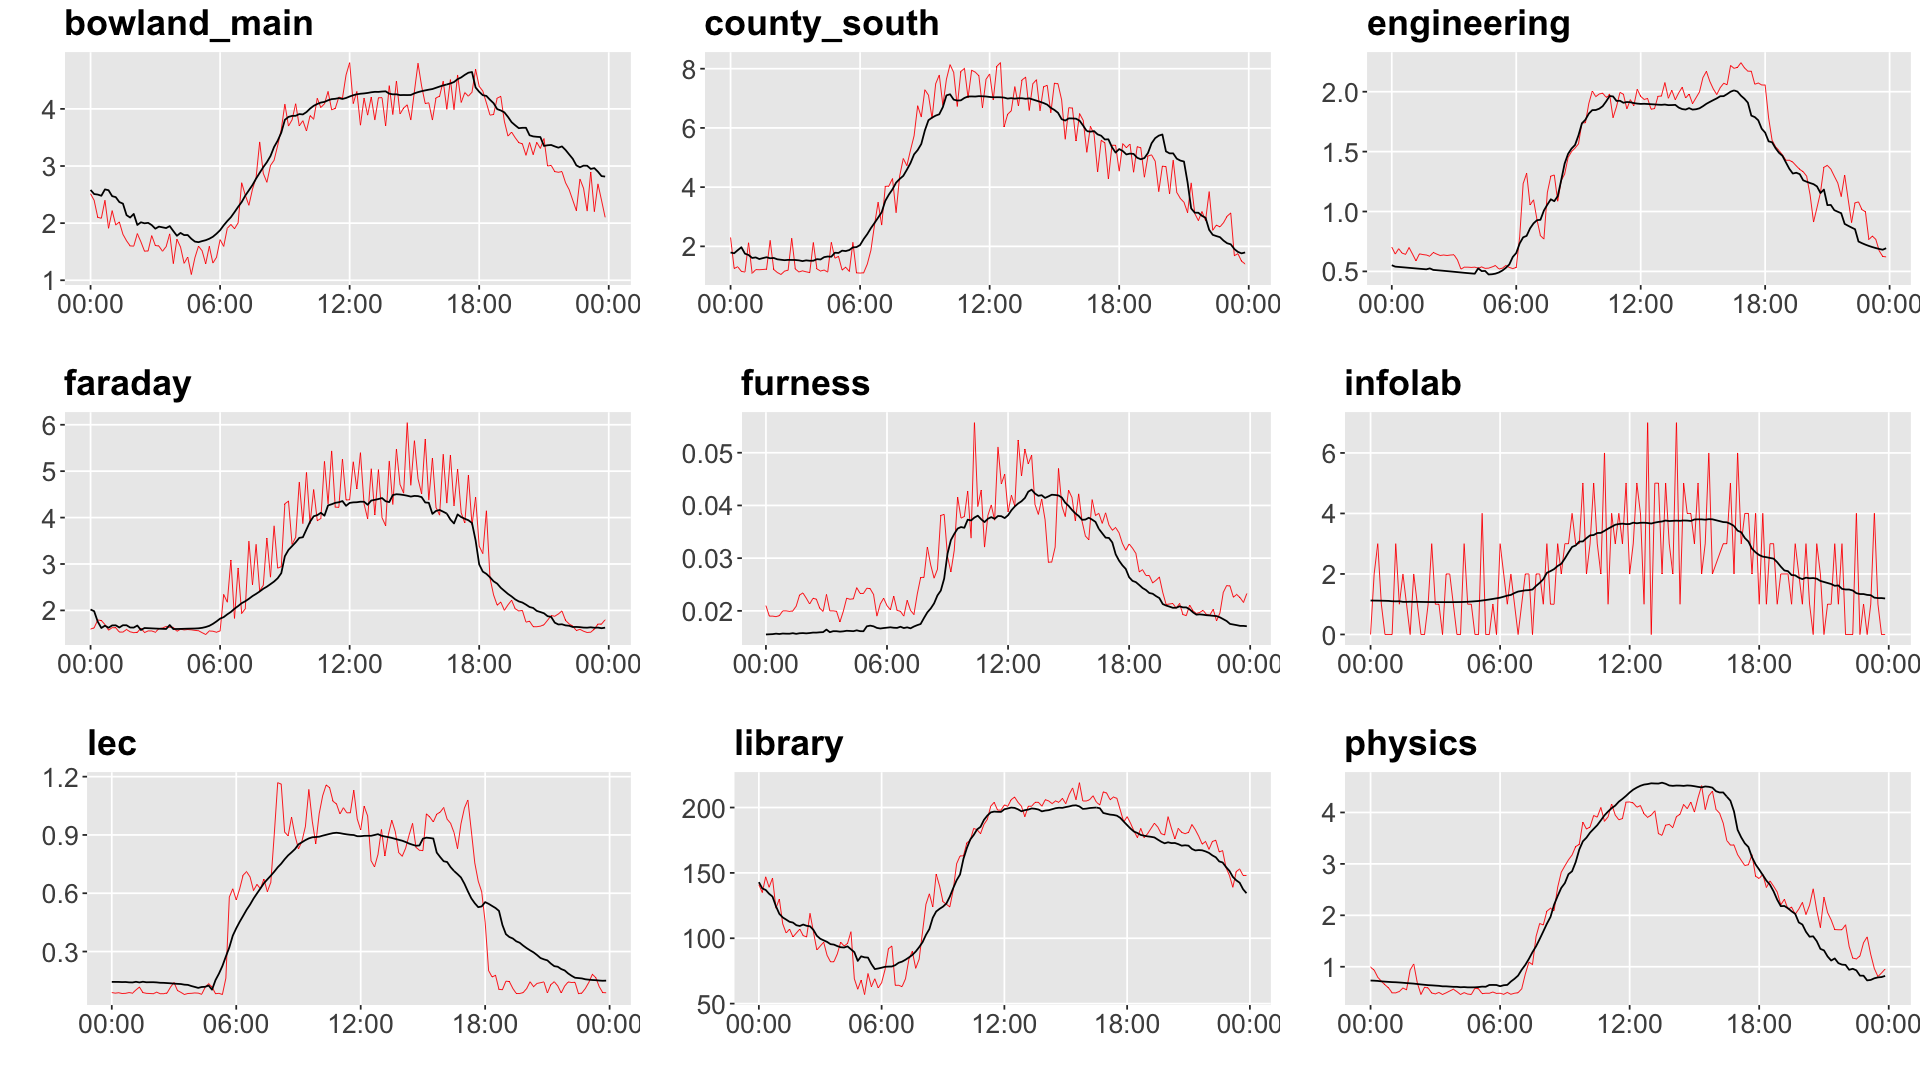

In [191]:
options(repr.plot.width=16, repr.plot.height=9) 
grid.arrange(forecastRes[[1]], forecastRes[[2]], forecastRes[[3]],
             forecastRes[[4]], forecastRes[[5]], forecastRes[[6]],
             forecastRes[[7]], forecastRes[[8]], forecastRes[[9]], nrow=3)